In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/masters

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/masters


In [2]:
%ls ./data/processed
# # T12H-X850M-Y880M_2013-01-01_2015-01-01/
# # T1H-X1700M-Y1760M_2013-01-01_2015-01-01/
# # T1H-X850M-Y880M_2013-01-01_2015-01-01/
# # T24H-X255M-Y220M_2013-01-01_2015-01-01/
# # T24H-X425M-Y440M_2013-01-01_2015-01-01/
# # T24H-X850M-Y880M_2013-01-01_2015-01-01/
# # T24H-X85M-Y110M_2013-01-01_2015-01-01/
# # T3H-X850M-Y880M_2013-01-01_2015-01-01/
# # T6H-X850M-Y880M_2013-01-01_2015-01-01/

T12H-X850M-Y880M_2013-01-01_2015-01-01/
T1H-X1700M-Y1760M_2013-01-01_2015-01-01/
T1H-X850M-Y880M_2013-01-01_2015-01-01/
T24H-X255M-Y220M_2013-01-01_2015-01-01/
T24H-X425M-Y440M_2013-01-01_2015-01-01/
T24H-X850M-Y880M_2013-01-01_2015-01-01/
T24H-X850M-Y880M_2013-01-01_2017-01-01/
T24H-X85M-Y110M_2013-01-01_2015-01-01/
T3H-X850M-Y880M_2013-01-01_2015-01-01/
T6H-X850M-Y880M_2013-01-01_2015-01-01/


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.metrics import best_threshold
from utils.utils import write_json, Timer
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, best_threshold, get_y_pred, \
                                get_y_pred_by_thresholds, best_thresholds
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics
from trainers.generic_trainer import train_model
from utils.plots import im
from utils.utils import pshape, get_data_sub_paths
from models.model_result import save_metrics,save_results, compare_models, compare_all_models, get_metrics_table, \
                            get_models_metrics, get_models_results
from models.st_resnet_models import STResNet, STResNetExtra
from models.st_resnet_models import train_epoch_for_st_res_net, train_epoch_for_st_res_net_extra
from models.st_resnet_models import evaluate_st_res_net, evaluate_st_res_net_extra
import pandas as pd
from pprint import pprint
pd.set_option('display.max_columns', None)

In [4]:
data_sub_paths = get_data_sub_paths()
pprint(data_sub_paths)
data_sub_path = 'T1H-X1700M-Y1760M_2013-01-01_2015-01-01'

['T24H-X85M-Y110M_2013-01-01_2015-01-01',
 'T24H-X425M-Y440M_2013-01-01_2015-01-01',
 'T24H-X850M-Y880M_2013-01-01_2015-01-01',
 'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
 'T1H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X255M-Y220M_2013-01-01_2015-01-01',
 'T12H-X850M-Y880M_2013-01-01_2015-01-01',
 'T6H-X850M-Y880M_2013-01-01_2015-01-01',
 'T3H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X850M-Y880M_2013-01-01_2017-01-01']


## Load data

In [5]:
USE_EXTRA = False # todo move extra model to own notebook

conf = BaseConf()

if USE_EXTRA:
    conf.model_name = "ST-RESNET-Extra"  # needs to be created
else:     
    conf.model_name = "ST-RESNET"  # needs to be created

conf.data_path = f"./data/processed/{data_sub_path}/"

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path =  f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=conf.model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed( conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

2019-11-28T12:59:46 | root | INFO | =====================================BEGIN=====================================
2019-11-28T12:59:46 | root | INFO | Device: cuda:0


In [6]:
conf.batch_size = 64

# CRIME DATA
data_group = GridDataGroup(data_path=conf.data_path,
                           conf=conf)

loaders = GridDataLoaders(data_group=data_group,
                          conf=conf)

2019-11-28T12:59:55 | root | INFO | 	t_range shape (17521,)


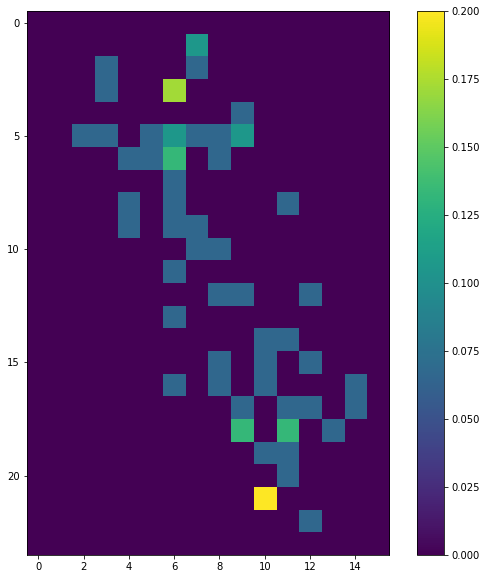

In [7]:
im(data_group.crimes[100:105].mean(0))

## Model setup

In [0]:
# SET THE HYPER PARAMETERS
conf.dropout = 0#0.2
conf.weight_decay = 0#1e-8
conf.lr = 4e-3

conf.checkpoint =  "best" # "latest" # 
conf.resume = False
conf.freqstr = data_group.t_range.freqstr  
conf.early_stopping = False
conf.max_epochs = 120

# SET LOSS FUNCTION
# size averaged - so more epochs or larger lr for smaller batches
loss_function = nn.MSELoss()  

# SETUP MODEL
dataset = loaders.train_loader.dataset
_, h_size, w_size = dataset.crimes.shape
_, n_ext_features = dataset.time_vectors.shape


# todo setup - hyper-optimiser
conf.n_layers = 12  # number of res-unit layers
conf.n_channels = 5 # inner channel size of the res-units 

if USE_EXTRA:
    train_epoch_fn = train_epoch_for_st_res_net_extra
    evaluate_fn = evaluate_st_res_net_extra
    model = STResNetExtra(n_layers=conf.n_layers,
                          n_channels=conf.n_channels,
                          y_size=h_size,
                          x_size=w_size,

                          lc=dataset.n_steps_c,
                          lp=dataset.n_steps_p,
                          lq=dataset.n_steps_q,

                          n_ext_features=n_ext_features,
                          n_demog_features=37,
                          n_demog_channels=10,
                          n_demog_layers=3,

                          n_gsv_features=512,
                          n_gsv_channels=10,
                          n_gsv_layers=3)
else:
    train_epoch_fn = train_epoch_for_st_res_net
    evaluate_fn = evaluate_st_res_net
    model = STResNet(n_layers=conf.n_layers,
                     n_channels=conf.n_channels,
                     y_size=h_size,
                     x_size=w_size,

                     lc=dataset.n_steps_c,
                     lp=dataset.n_steps_p,
                     lq=dataset.n_steps_q,

                     n_ext_features=n_ext_features)    
    
# todo implement model_arch for res-net
model.to(conf.device)

# SETUP OPTIMISER
parameters = model.parameters()
# todo (optional): setup model parameters dynamically 

optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

if conf.resume:
    try:
        # resume from previous check point or resume from best validaton score checkpoint
        # load model state
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                      map_location=conf.device.type)
        model.load_state_dict(model_state_dict)
        
        # load optimiser state
        optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                          map_location=conf.device.type)
        optimiser.load_state_dict(optimiser_state_dict) 

        # new optimiser hyper-parameters
        optimiser.param_groups[0]['lr'] = conf.lr
        optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

    except Exception as e:
        log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")


## Training loop

2019-11-28T13:01:37 | root | INFO | lr: 		0.004
2019-11-28T13:01:37 | root | INFO | weight_decay: 	0
2019-11-28T13:01:37 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-28T13:01:37 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': 'H',
 'lr': 0.004,
 'max_epochs': 120,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/models/ST-RESNET/',
 'n_channels': 5,
 'n_layers': 12,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 6,
 'pad_width': 0,
 'resume': False,
 'seed': 3,
 'seq_len': 1,
 'shaper_threshold': 0,
 'shaper_top_k': -1,
 'shuffle': False,
 'sub_sample_test_set': 0,
 'sub_sample_train_set': 1,
 'sub_sample_va

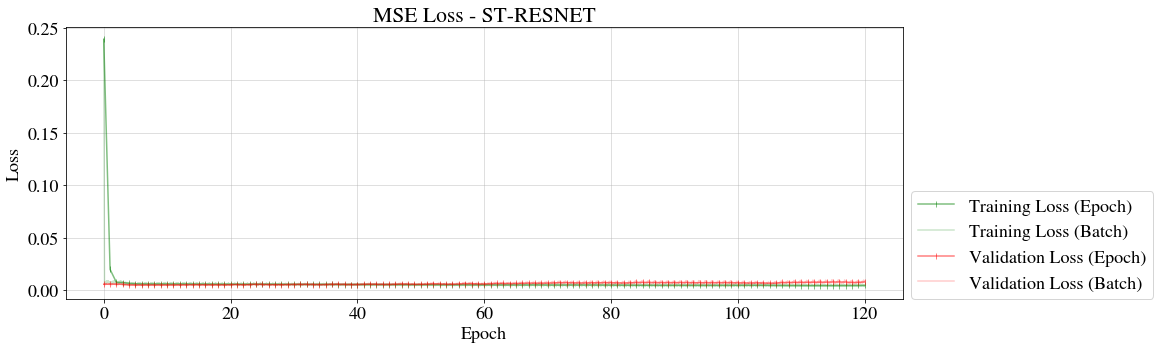

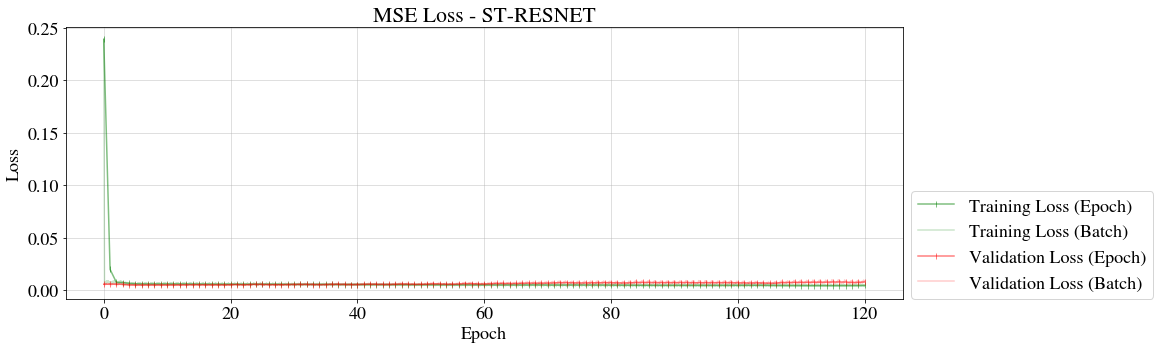

In [9]:
log.info(f"lr: \t\t{optimiser.param_groups[0]['lr']}")
log.info(f"weight_decay: \t{optimiser.param_groups[0]['weight_decay']}")
trn_epoch_losses, val_epoch_losses, stopped_early = train_model(model=model,
                                           optimiser=optimiser,
                                           loaders=loaders,
                                           train_epoch_fn=train_epoch_fn,
                                           loss_fn=loss_function,
                                           conf=conf)    

print(f"stopped_early: {stopped_early}") # use the current epoch instead
# if stopped_early -> continue with best_model - new hyper-parameters -> no n 

In [0]:
lim = 110

plt.figure(figsize=(15,5))
for x in [trn_epoch_losses, val_epoch_losses]:
    plt.plot(x[-lim:],marker='|',alpha=.5)
plt.show()

plt.figure(figsize=(15,5))
for x in [trn_epoch_losses, val_epoch_losses]:
    plt.plot(np.diff(x[-lim:]),marker='|',alpha=.5)
plt.show()


## Evaluation

In [0]:
# Load latest or best validation model
# conf.checkpoint = "latest"
conf.checkpoint = "best"

log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

# resume from previous check point or resume from best validaton score checkpoint
# load model state
log.info(f"loading model from {conf.model_path}")
model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                map_location=conf.device.type)
model.load_state_dict(model_state_dict)

2019-11-24T23:22:55 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-24T23:22:55 | root | INFO | loading model from ./data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/models/ST-RESNET/


<All keys matched successfully>

In [0]:
trn_y_counts, trn_y_true, trn_probas_pred, trn_t_range = evaluate_fn(model=model,
                                                                     batch_loader=loaders.train_loader,
                                                                     conf=conf) 
thresh = best_threshold(trn_y_true, trn_probas_pred) 

tst_y_counts, tst_y_true, tst_probas_pred, tst_t_range = evaluate_fn(model=model,
                                                                     batch_loader=loaders.test_loader,
                                                                     conf=conf)

tst_y_true = np.expand_dims(tst_y_true, axis=1)
tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1) 

tst_y_true = data_group.shaper.squeeze(tst_y_true)
tst_probas_pred = data_group.shaper.squeeze(tst_probas_pred)


tst_y_pred = get_y_pred(thresh, tst_probas_pred)
save_metrics(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)

save_results(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)

2019-11-24T23:23:17 | root | INFO | f1_score: 0.358566004320234 at index 1402566, new threshold 0.06113992631435394


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2019-11-24T23:23:42 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                MAE:                0.12705580723549387
                RMSE:               0.3035243276839758
                ROC AUC:            0.756783916140034                
                Average Precision:  0.26778611018890475
                Precision:          0.2518785068194993
                Recall:             0.4791519287586867
                Accuracy:           0.7982039148436201
                MCC:                0.24081776277506847          
        
2019-11-24T23:23:42 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.756783916140034
                Average Precision:  0.26778611018890475                
                Precision:          0.2518785068194993
                Recall:             0.4791519287586867
                Accuracy:           0.7982039148436201
                MCC:                0.240817762

In [0]:
compare_all_models(conf.data_path)

AttributeError: 'str' object has no attribute 'model_name'

In [0]:
models_metrics = get_models_metrics(data_path=conf.data_path)

get_metrics_table(models_metrics)

In [0]:
models_results = get_models_results(data_path=conf.data_path)

In [0]:
m = models_results[0].probas_pred
hspaehsaper



(399, 1, 702)

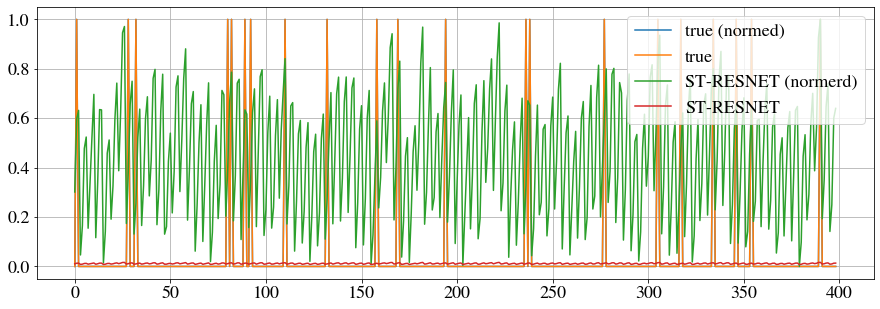

In [0]:
m = models_results[0]

def norm(x):
#     return x
    x = x - np.min(x)
    x = x / np.max(x)
    return x

i = 0
lim = 400
for m in models_results:
    plt.figure(figsize=(15,5))

    y_true = m.y_true[:lim,0,i]#.sum(1)
    plt.plot(norm(y_true),label='true (normed)')
    plt.plot(y_true,label='true')

    x0 = m.probas_pred[:lim,0,i]#.sum(1)
    plt.plot(norm(x0),label=f"{m.model_name} (normerd)")
    plt.plot(x0,label=m.model_name)

    plt.grid()
    plt.legend()
    plt.show()


In [0]:
m = models_results[1]
m.y_true.shape

(99, 1, 4935)

In [0]:
targets = [m.shaper for m in models_results]
for t in targets:
    print(t.l)

4935
4935
4935
4935
4935
4935


----------------------------------------------------------------------------------------------------

## All in one

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, best_threshold, get_y_pred
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics
from trainers.generic_trainer import train_model
from utils.plots import im
from utils.utils import pshape, get_data_sub_paths
from models.model_result import save_metrics, compare_models, get_models_metrics, get_models_results
from models.st_resnet_models import STResNet, STResNetExtra
from models.st_resnet_models import train_epoch_for_st_res_net, train_epoch_for_st_res_net_extra
from models.st_resnet_models import evaluate_st_res_net, evaluate_st_res_net_extra

In [0]:
data_sub_paths = get_data_sub_paths()
# data_sub_paths = ['T24H-X850M-Y880M_2013-01-01_2015-01-01']
data_sub_paths = [
    'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
    'T1H-X850M-Y880M_2013-01-01_2015-01-01',
    'T3H-X850M-Y880M_2013-01-01_2015-01-01',
    'T6H-X850M-Y880M_2013-01-01_2015-01-01',
    'T12H-X850M-Y880M_2013-01-01_2015-01-01',
    'T24H-X850M-Y880M_2013-01-01_2015-01-01',
    'T24H-X425M-Y440M_2013-01-01_2015-01-01',
    'T24H-X255M-Y220M_2013-01-01_2015-01-01',
    'T24H-X85M-Y110M_2013-01-01_2015-01-01',
]
data_sub_paths

['T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
 'T1H-X850M-Y880M_2013-01-01_2015-01-01',
 'T3H-X850M-Y880M_2013-01-01_2015-01-01',
 'T6H-X850M-Y880M_2013-01-01_2015-01-01',
 'T12H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X425M-Y440M_2013-01-01_2015-01-01',
 'T24H-X255M-Y220M_2013-01-01_2015-01-01',
 'T24H-X85M-Y110M_2013-01-01_2015-01-01']

2019-11-12T15:54:05 | root | INFO | 
========================= T1H-X1700M-Y1760M_2013-01-01_2015-01-01 =========================

2019-11-12T15:54:06 | root | INFO | =====================================BEGIN=====================================
2019-11-12T15:54:06 | root | INFO | Device: cuda:0
2019-11-12T15:54:09 | root | INFO | 	t_range shape (17521,)
2019-11-12T15:54:09 | root | INFO | lr: 		0.0005
2019-11-12T15:54:09 | root | INFO | weight_decay: 	1e-08
2019-11-12T15:54:09 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-12T15:54:09 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': 'H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed

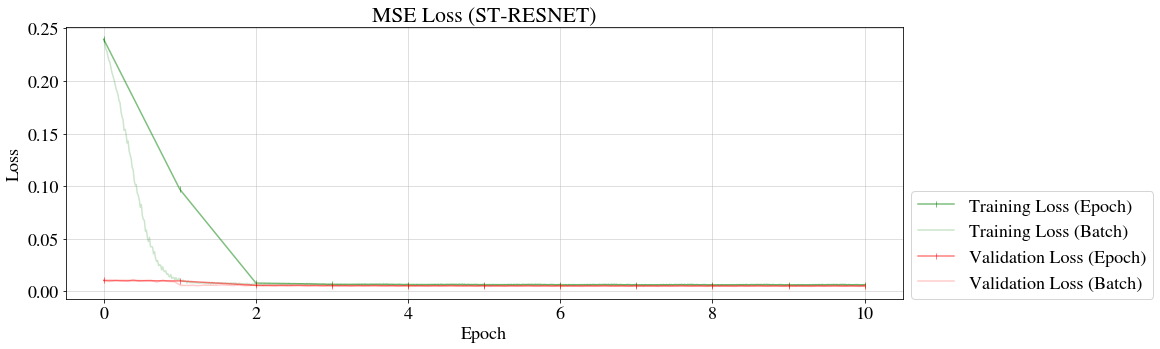

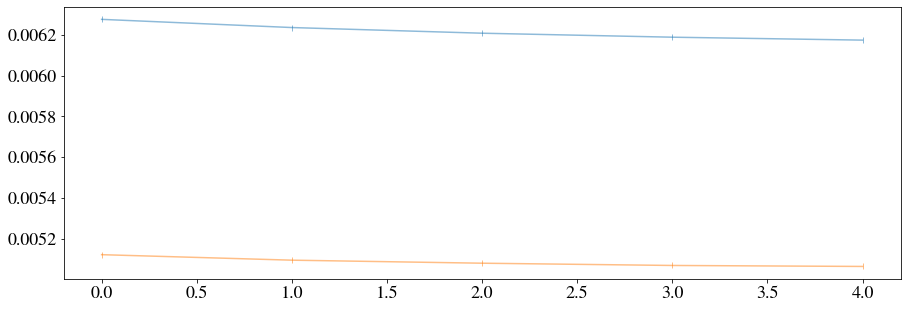

2019-11-12T15:54:42 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T15:54:42 | root | INFO | loading model from ./data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/models/ST-RESNET/
2019-11-12T15:54:45 | root | INFO | f1_score: 0.3499827279160476 at index 1424136, new threshold 0.06584414839744568


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2019-11-12T15:54:52 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                ROC AUC:            0.7521154780033475                
                Average Precision:  0.2653315491601486
                Precision:          0.2506714113065664
                Recall:             0.4660854729307977
                Accuracy:           0.7999511886429362
                MCC:                0.23548841565886533          
        
2019-11-12T15:54:52 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.7521154780033475
                Average Precision:  0.2653315491601486                
                Precision:          0.2506714113065664
                Recall:             0.4660854729307977
                Accuracy:           0.7999511886429362
                MCC:                0.23548841565886533          
        
2019-11-12T15:55:05 | root | INFO | 
                       ROC AUC  Avg. Precision

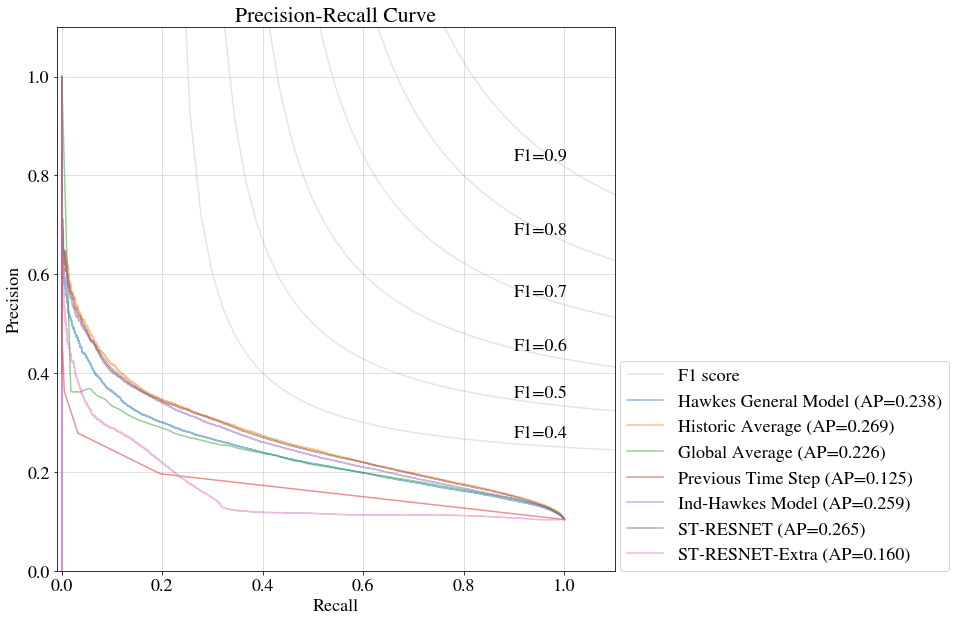

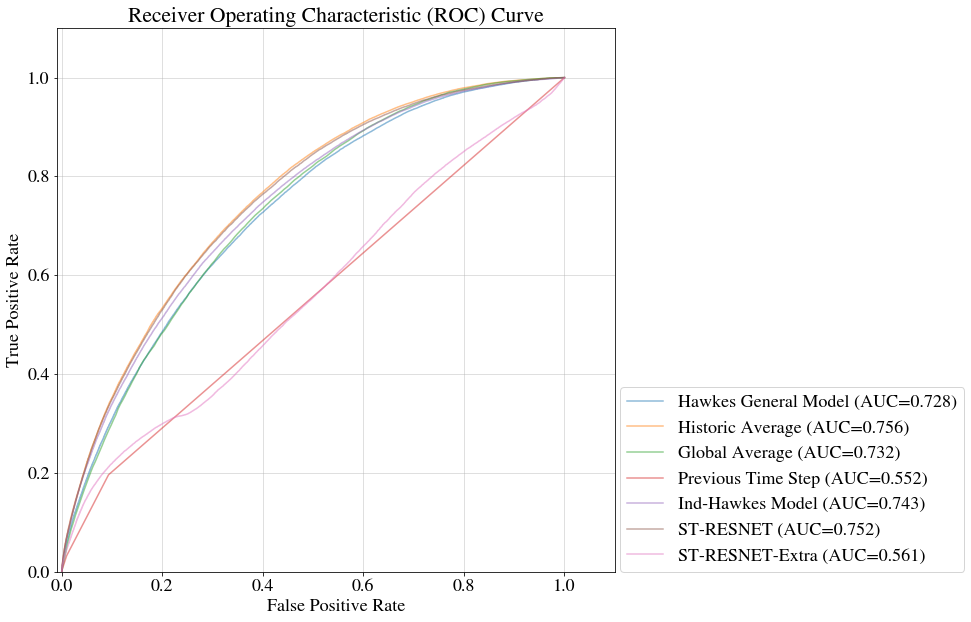

2019-11-12T15:55:06 | root | INFO | =====================================BEGIN=====================================
2019-11-12T15:55:07 | root | INFO | Device: cuda:0
2019-11-12T15:55:07 | root | INFO | 	t_range shape (17521,)
2019-11-12T15:55:07 | root | INFO | lr: 		0.0005
2019-11-12T15:55:07 | root | INFO | weight_decay: 	1e-08
2019-11-12T15:55:07 | root | INFO | 
 ====================== Training ST-RESNET-Extra ====================== 

2019-11-12T15:55:07 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': 'H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET-Extra',
 'model_path': './data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/',
 'n_channels': 3,
 'n_layers': 5,
 'n_steps_c': 3,


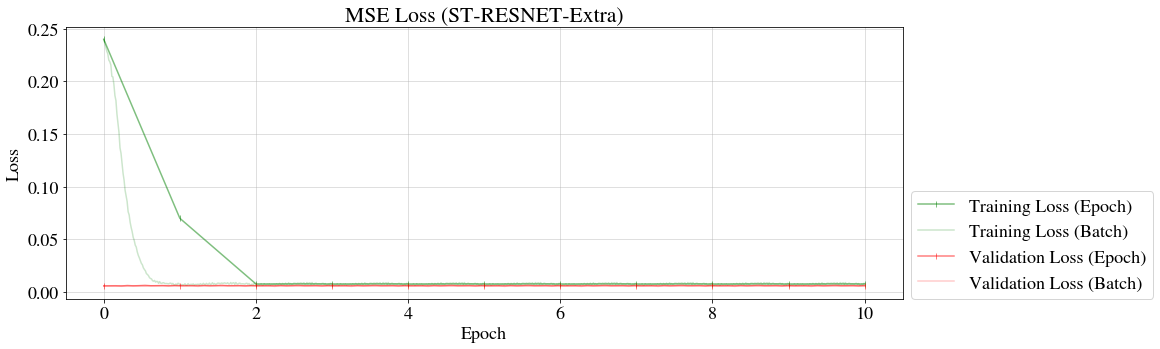

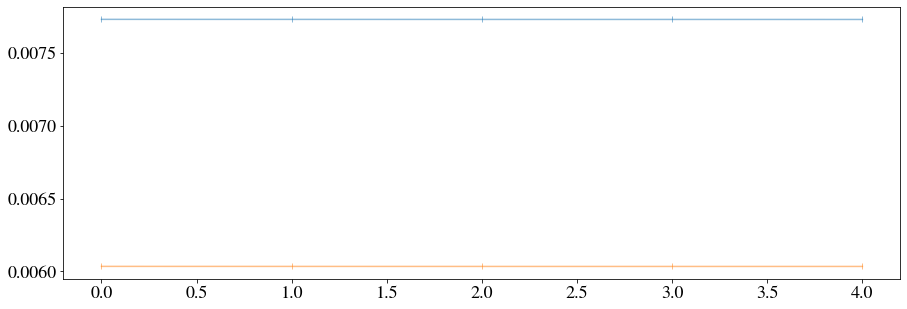

2019-11-12T15:55:53 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T15:55:53 | root | INFO | loading model from ./data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/
2019-11-12T15:55:56 | root | INFO | f1_score: 0.10789669805800724 at index 0, new threshold 0.0
2019-11-12T15:56:03 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.42568554226489974                
                Average Precision:  0.08444700223538483
                Precision:          0.10380404615912935
                Recall:             1.0
                Accuracy:           0.10380404615912935
                MCC:                0.0          
        


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-12T15:56:03 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.42568554226489974
                Average Precision:  0.08444700223538483                
                Precision:          0.10380404615912935
                Recall:             1.0
                Accuracy:           0.10380404615912935
                MCC:                0.0          
        


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-12T15:56:08 | root | INFO | 
                       ROC AUC  Avg. Precision  ...  Accuracy  Matthews Corrcoef
Model Name                                      ...                             
Historic Average      0.755682        0.268672  ...  0.787185           0.240860
ST-RESNET             0.752115        0.265332  ...  0.799951           0.235488
Ind-Hawkes Model      0.742517        0.259200  ...  0.790992           0.226882
Hawkes General Model  0.728275        0.238279  ...  0.788452           0.205692
Global Average        0.731535        0.225963  ...  0.749872           0.206606
Previous Time Step    0.552144        0.125175  ...  0.833134           0.103166
ST-RESNET-Extra       0.425686        0.084447  ...  0.103804           0.000000

[7 rows x 7 columns]


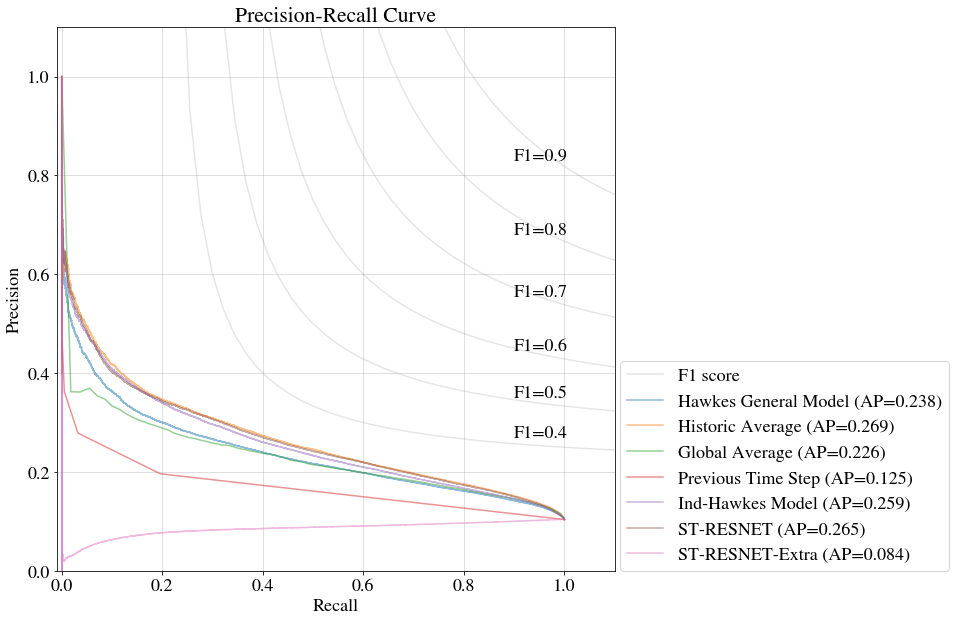

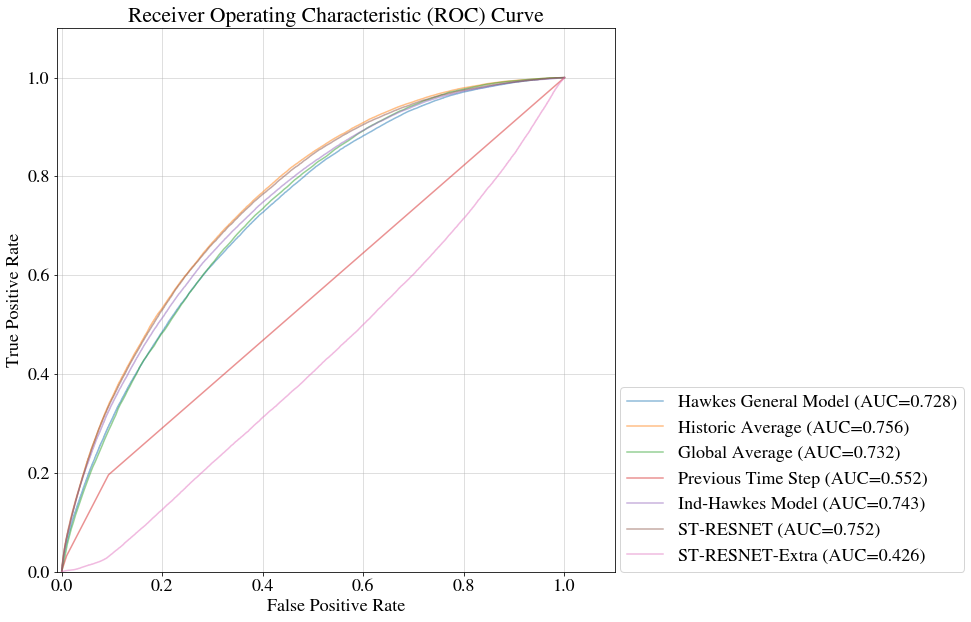

2019-11-12T15:56:10 | root | INFO | 
========================= T1H-X850M-Y880M_2013-01-01_2015-01-01 =========================

2019-11-12T15:56:10 | root | INFO | =====================================BEGIN=====================================
2019-11-12T15:56:11 | root | INFO | Device: cuda:0
2019-11-12T15:56:13 | root | INFO | 	t_range shape (17521,)
2019-11-12T15:56:15 | root | INFO | lr: 		0.0005
2019-11-12T15:56:15 | root | INFO | weight_decay: 	1e-08
2019-11-12T15:56:15 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-12T15:56:15 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T1H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': 'H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T1H

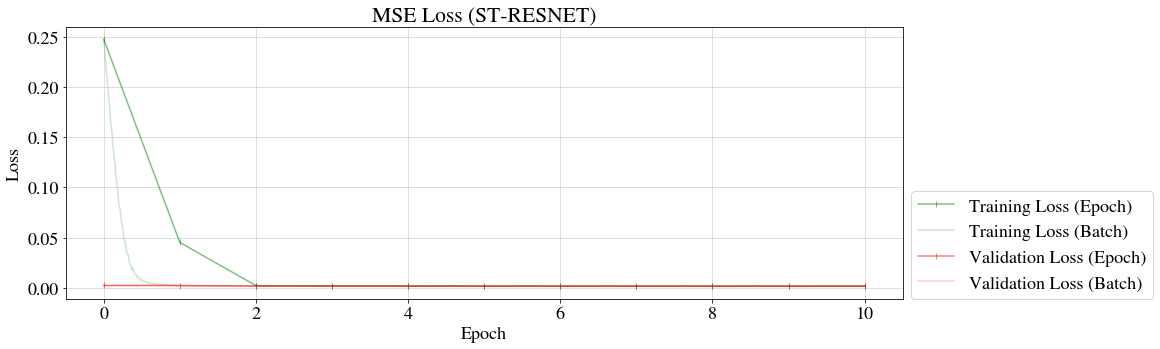

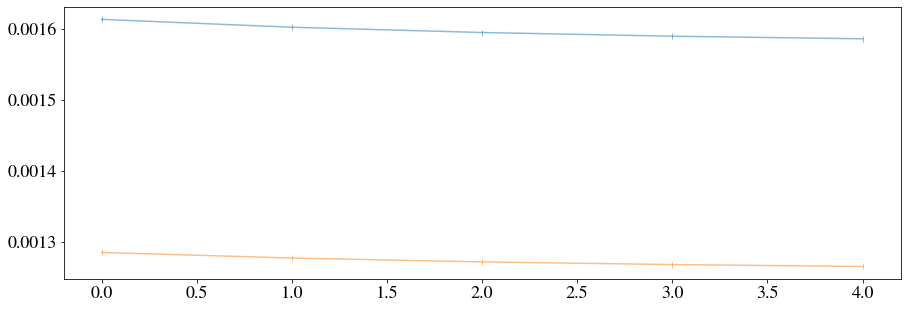

2019-11-12T15:56:56 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T15:56:56 | root | INFO | loading model from ./data/processed/T1H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET/
2019-11-12T15:57:04 | root | INFO | f1_score: 0.1669063757313775 at index 4044269, new threshold 0.026886098086833954
2019-11-12T15:57:18 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                ROC AUC:            0.7342108039581593                
                Average Precision:  0.09540267401505739
                Precision:          0.1110011476855009
                Recall:             0.251360665925912
                Accuracy:           0.9129225258862608
                MCC:                0.12610680453443654          
        
2019-11-12T15:57:18 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.7342108039581593
                Average Precision:  0.09540267401505739     

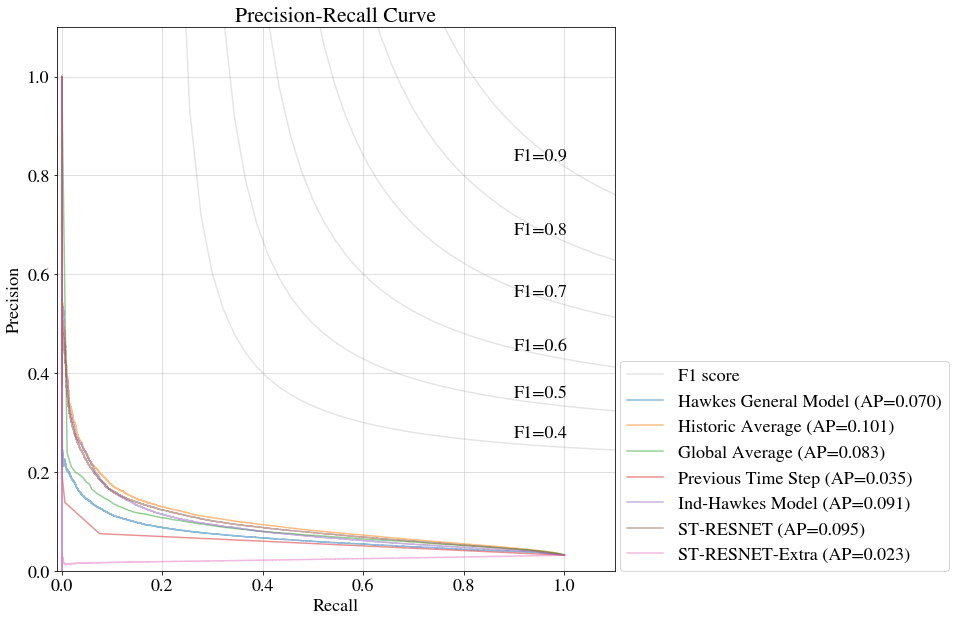

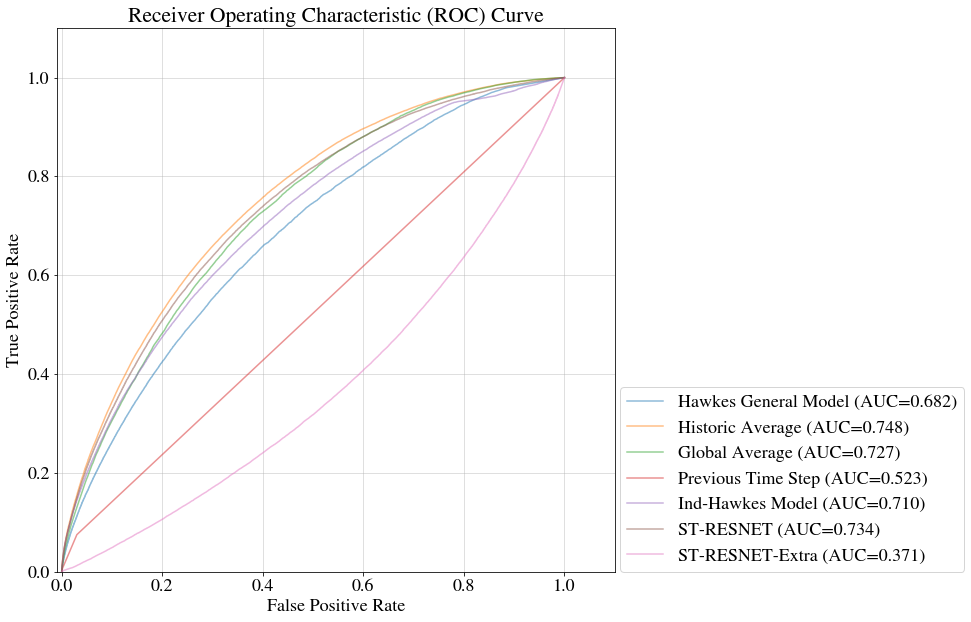

2019-11-12T15:57:49 | root | INFO | =====================================BEGIN=====================================
2019-11-12T15:57:50 | root | INFO | Device: cuda:0
2019-11-12T15:57:50 | root | INFO | 	t_range shape (17521,)
2019-11-12T15:57:52 | root | INFO | lr: 		0.0005
2019-11-12T15:57:52 | root | INFO | weight_decay: 	1e-08
2019-11-12T15:57:52 | root | INFO | 
 ====================== Training ST-RESNET-Extra ====================== 

2019-11-12T15:57:52 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T1H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': 'H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET-Extra',
 'model_path': './data/processed/T1H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/',
 'n_channels': 3,
 'n_layers': 5,
 'n_steps_c': 3,
 'n_

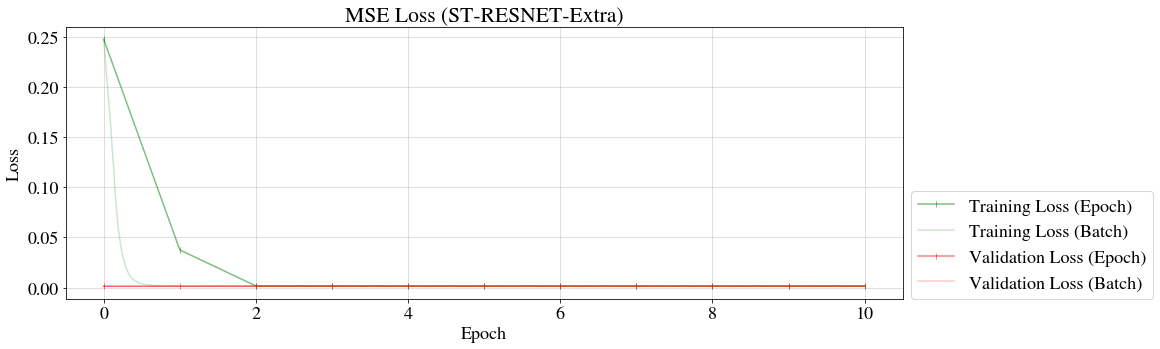

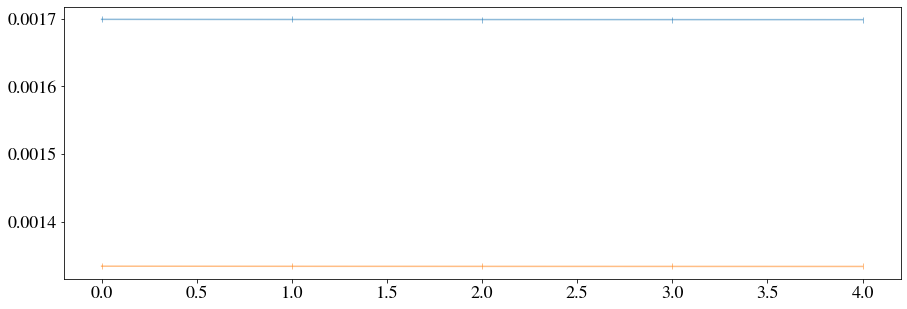

2019-11-12T15:58:44 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T15:58:44 | root | INFO | loading model from ./data/processed/T1H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/
2019-11-12T15:58:55 | root | INFO | f1_score: 0.03111008968805546 at index 0, new threshold 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-12T15:59:09 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.3511271789912144                
                Average Precision:  0.022007215101566502
                Precision:          0.03152963782392711
                Recall:             1.0
                Accuracy:           0.03152963782392711
                MCC:                0.0          
        
2019-11-12T15:59:09 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.3511271789912144
                Average Precision:  0.022007215101566502                
                Precision:          0.03152963782392711
                Recall:             1.0
                Accuracy:           0.03152963782392711
                MCC:                0.0          
        


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-12T15:59:26 | root | INFO | 
                       ROC AUC  Avg. Precision  ...  Accuracy  Matthews Corrcoef
Model Name                                      ...                             
Historic Average      0.747532        0.101228  ...  0.914354           0.132059
ST-RESNET             0.734211        0.095403  ...  0.912923           0.126107
Ind-Hawkes Model      0.710276        0.090826  ...  0.920120           0.115217
Global Average        0.727132        0.082812  ...  0.894656           0.115359
Hawkes General Model  0.681533        0.069940  ...  0.907360           0.089510
Previous Time Step    0.522583        0.035261  ...  0.941682           0.045072
ST-RESNET-Extra       0.351127        0.022007  ...  0.031530           0.000000

[7 rows x 7 columns]


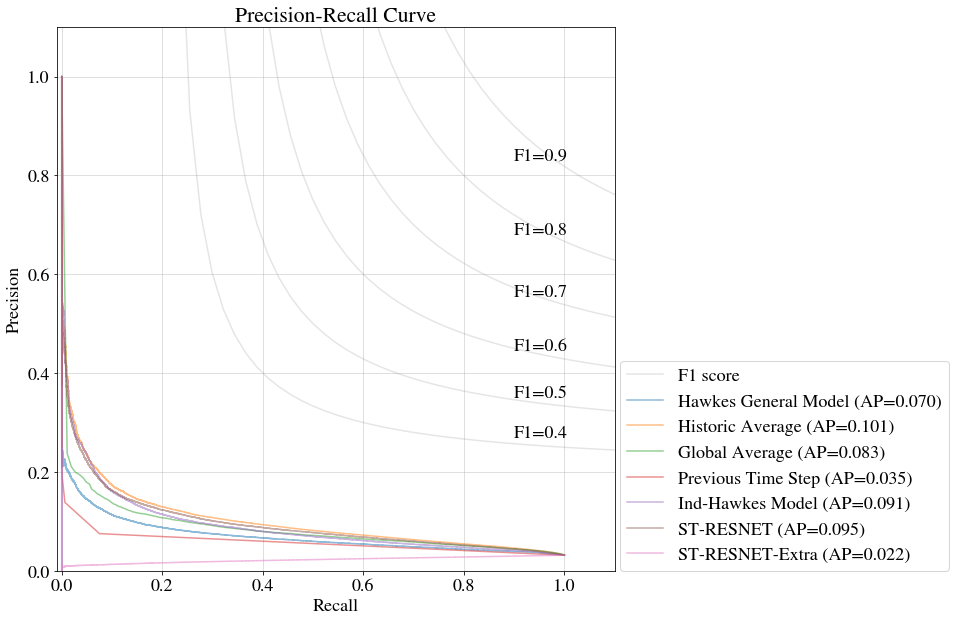

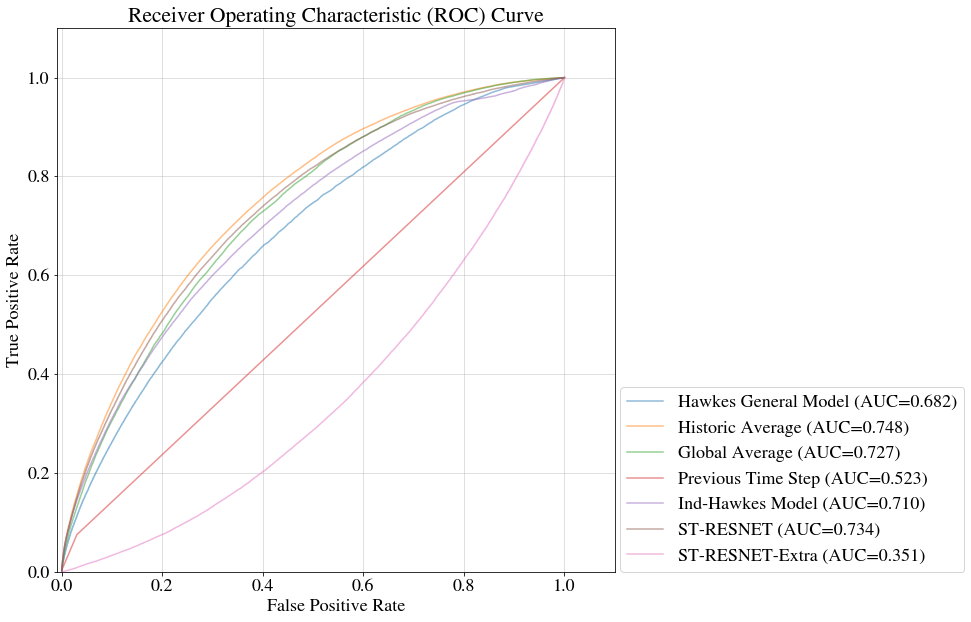

2019-11-12T15:59:28 | root | INFO | 
========================= T3H-X850M-Y880M_2013-01-01_2015-01-01 =========================

2019-11-12T15:59:29 | root | INFO | =====================================BEGIN=====================================
2019-11-12T15:59:30 | root | INFO | Device: cuda:0
2019-11-12T15:59:32 | root | INFO | 	t_range shape (5841,)
2019-11-12T15:59:32 | root | INFO | lr: 		0.0005
2019-11-12T15:59:32 | root | INFO | weight_decay: 	1e-08
2019-11-12T15:59:32 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-12T15:59:32 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T3H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '3H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T3H

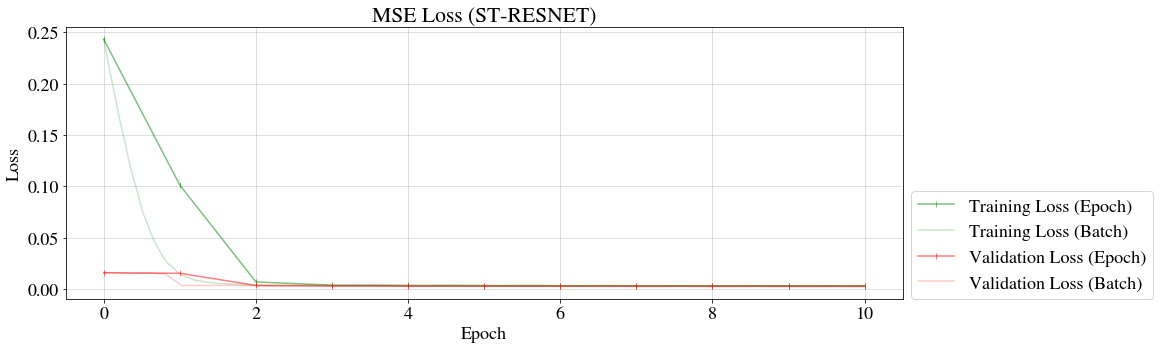

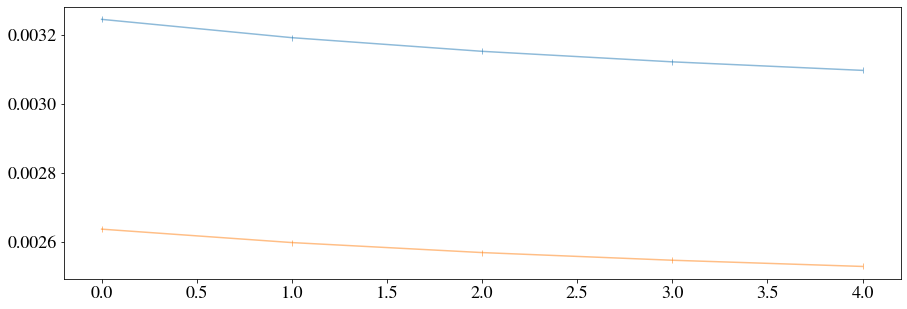

2019-11-12T15:59:53 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T15:59:53 | root | INFO | loading model from ./data/processed/T3H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET/
2019-11-12T15:59:56 | root | INFO | f1_score: 0.30537513997760357 at index 1411346, new threshold 0.041216667741537094
2019-11-12T16:00:00 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                ROC AUC:            0.7325045039216935                
                Average Precision:  0.22838891981429799
                Precision:          0.20552786075746582
                Recall:             0.4415069130954068
                Accuracy:           0.8005056177772073
                MCC:                0.2002032529429658          
        
2019-11-12T16:00:00 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.7325045039216935
                Average Precision:  0.22838891981429799   

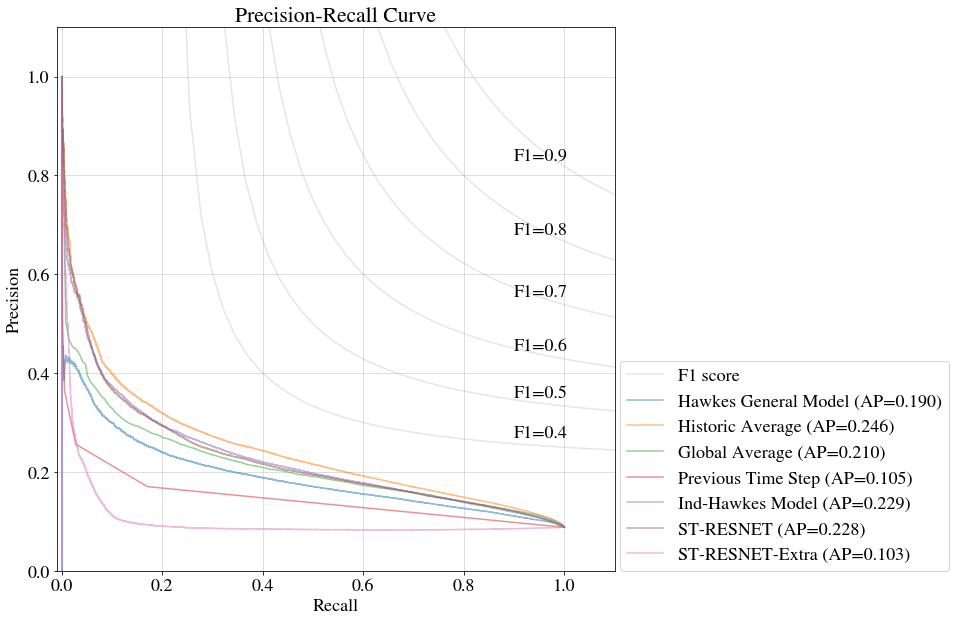

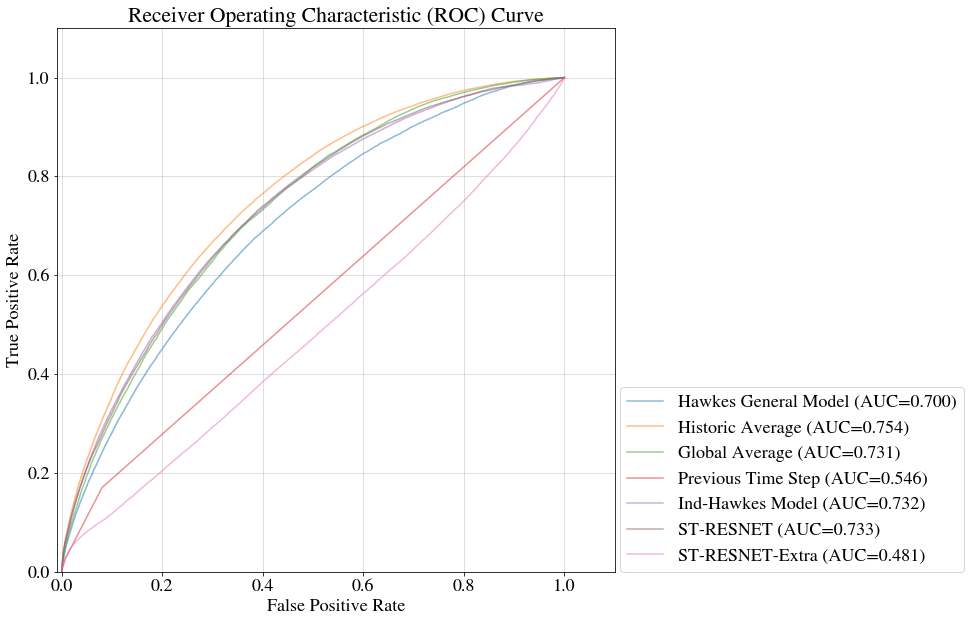

2019-11-12T16:00:15 | root | INFO | =====================================BEGIN=====================================
2019-11-12T16:00:15 | root | INFO | Device: cuda:0
2019-11-12T16:00:16 | root | INFO | 	t_range shape (5841,)
2019-11-12T16:00:16 | root | INFO | lr: 		0.0005
2019-11-12T16:00:16 | root | INFO | weight_decay: 	1e-08
2019-11-12T16:00:16 | root | INFO | 
 ====================== Training ST-RESNET-Extra ====================== 

2019-11-12T16:00:16 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T3H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '3H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET-Extra',
 'model_path': './data/processed/T3H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/',
 'n_channels': 3,
 'n_layers': 5,
 'n_steps_c': 3,
 'n_

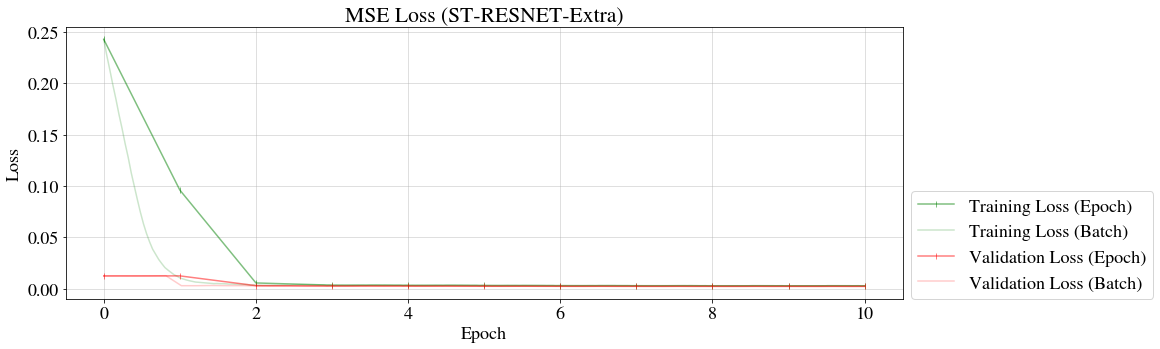

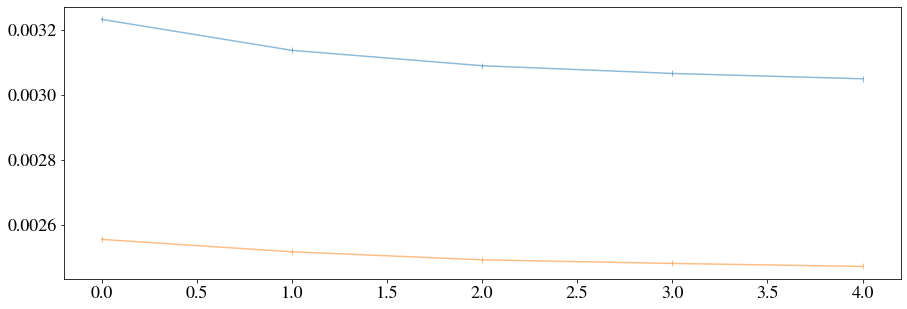

2019-11-12T16:00:42 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T16:00:42 | root | INFO | loading model from ./data/processed/T3H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/
2019-11-12T16:00:46 | root | INFO | f1_score: 0.30211949197533383 at index 2130567, new threshold 0.043008726090192795
2019-11-12T16:00:50 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7217543607868899                
                Average Precision:  0.22292589088885767
                Precision:          0.20586349594917527
                Recall:             0.4289965383914654
                Accuracy:           0.8039625743004967
                MCC:                0.19706226306943272          
        
2019-11-12T16:00:50 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7217543607868899
                Average Precision:  0.2

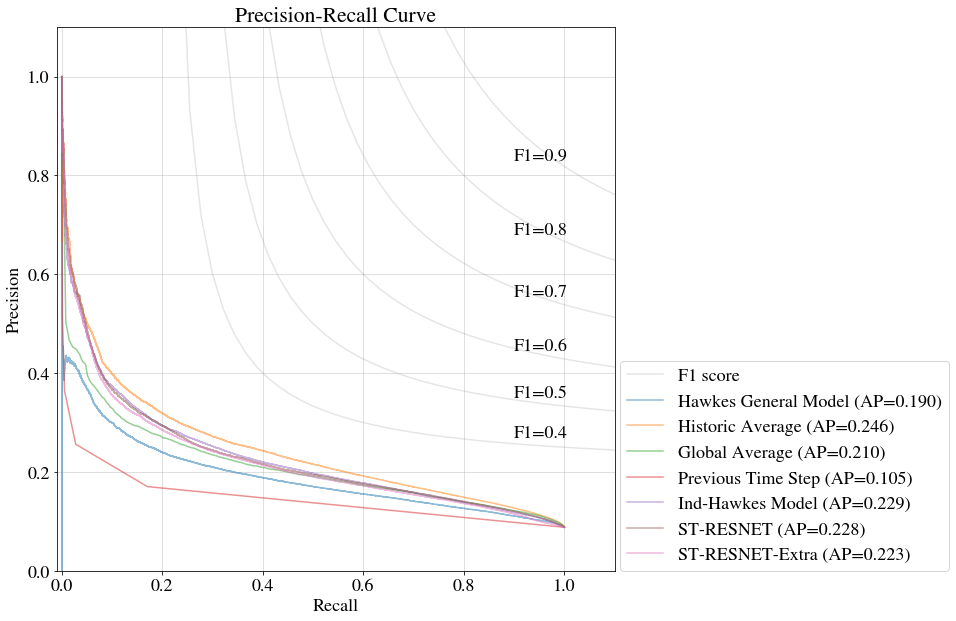

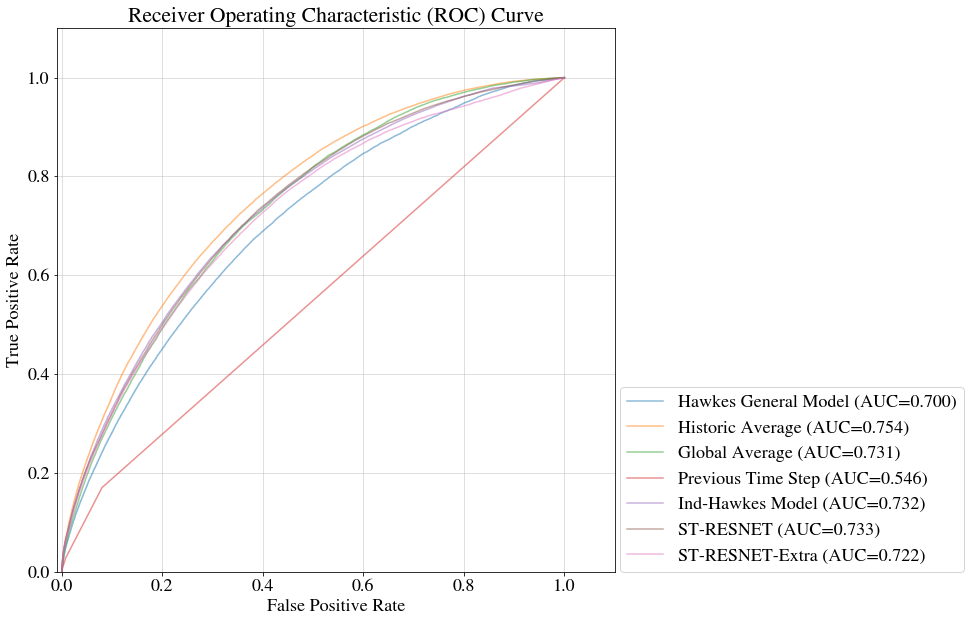

2019-11-12T16:00:57 | root | INFO | 
========================= T6H-X850M-Y880M_2013-01-01_2015-01-01 =========================

2019-11-12T16:01:00 | root | INFO | =====================================BEGIN=====================================
2019-11-12T16:01:00 | root | INFO | Device: cuda:0
2019-11-12T16:01:02 | root | INFO | 	t_range shape (2921,)
2019-11-12T16:01:03 | root | INFO | lr: 		0.0005
2019-11-12T16:01:03 | root | INFO | weight_decay: 	1e-08
2019-11-12T16:01:03 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-12T16:01:03 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T6H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '6H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T6H

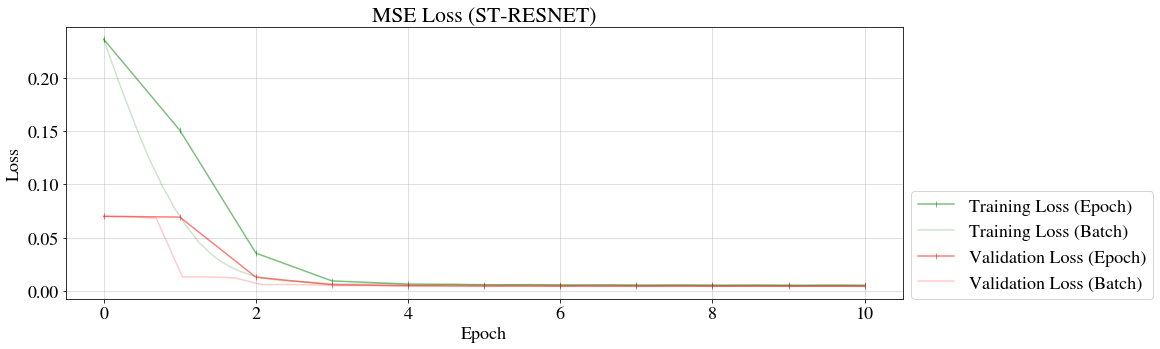

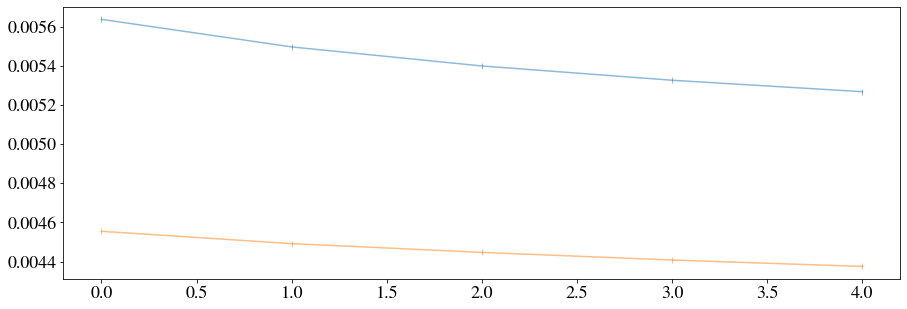

2019-11-12T16:01:20 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T16:01:20 | root | INFO | loading model from ./data/processed/T6H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET/
2019-11-12T16:01:22 | root | INFO | f1_score: 0.4358607817140826 at index 860121, new threshold 0.05467062443494797
2019-11-12T16:01:24 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                ROC AUC:            0.7436304723672293                
                Average Precision:  0.3756552007177666
                Precision:          0.311169184254626
                Recall:             0.5883408667907472
                Accuracy:           0.7238145220601361
                MCC:                0.2701313077675178          
        
2019-11-12T16:01:24 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.7436304723672293
                Average Precision:  0.3756552007177666          

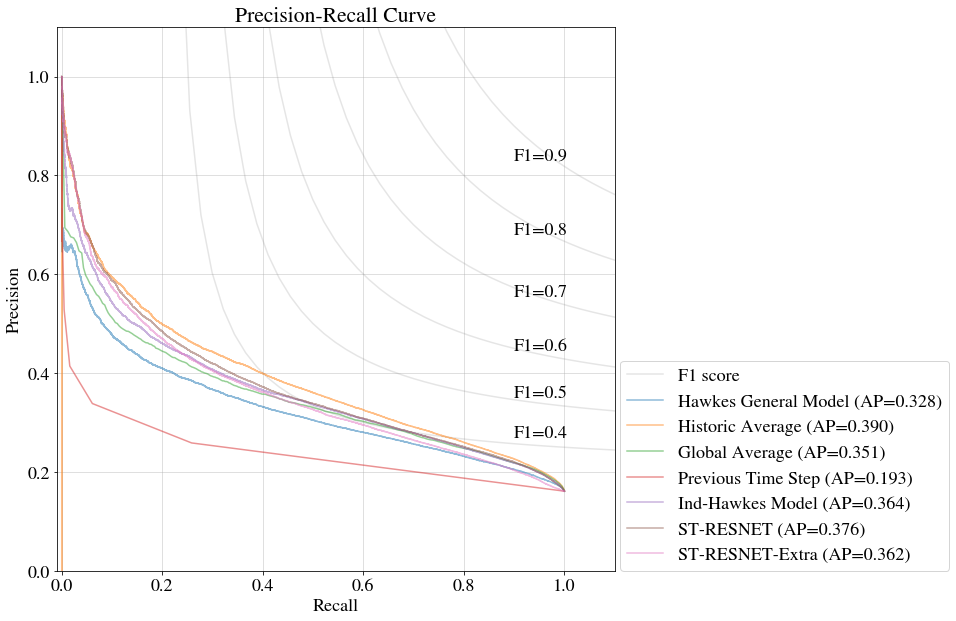

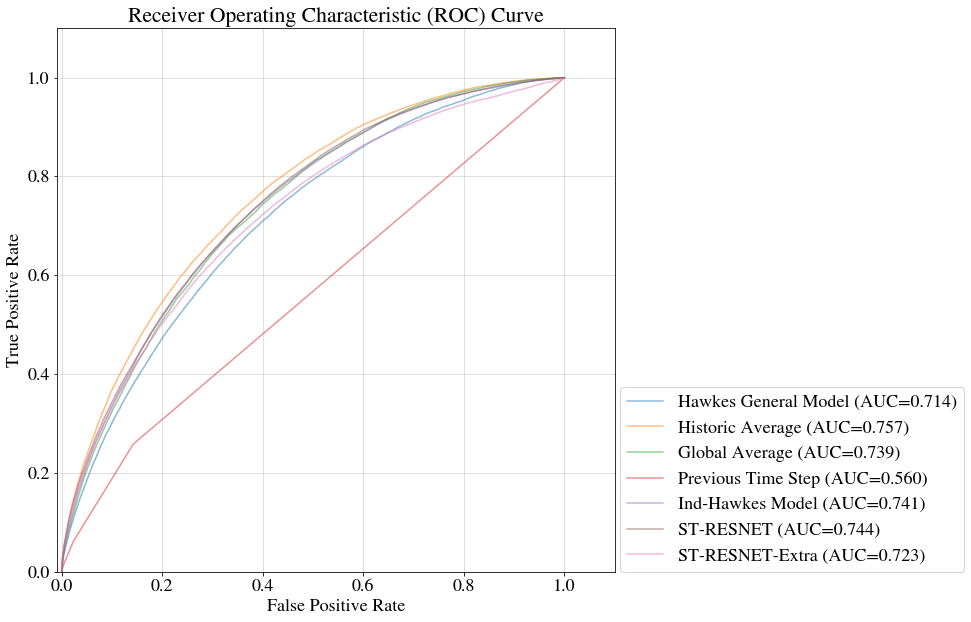

2019-11-12T16:01:36 | root | INFO | =====================================BEGIN=====================================
2019-11-12T16:01:37 | root | INFO | Device: cuda:0
2019-11-12T16:01:37 | root | INFO | 	t_range shape (2921,)
2019-11-12T16:01:37 | root | INFO | lr: 		0.0005
2019-11-12T16:01:37 | root | INFO | weight_decay: 	1e-08
2019-11-12T16:01:37 | root | INFO | 
 ====================== Training ST-RESNET-Extra ====================== 

2019-11-12T16:01:37 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T6H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '6H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET-Extra',
 'model_path': './data/processed/T6H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/',
 'n_channels': 3,
 'n_layers': 5,
 'n_steps_c': 3,
 'n_

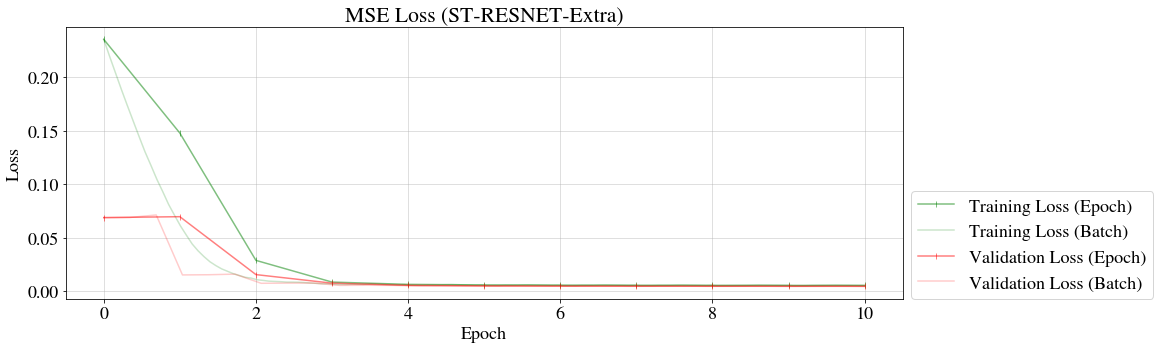

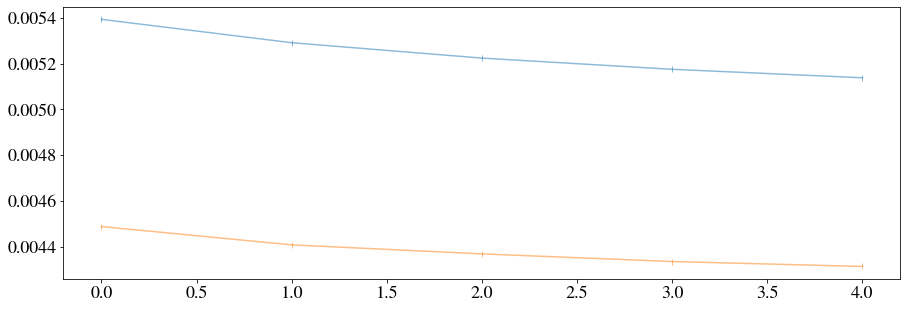

2019-11-12T16:01:55 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T16:01:55 | root | INFO | loading model from ./data/processed/T6H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/
2019-11-12T16:01:57 | root | INFO | f1_score: 0.43506146839320625 at index 1031431, new threshold 0.06335195899009705
2019-11-12T16:01:59 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7342055777425065                
                Average Precision:  0.3699692880277589
                Precision:          0.30646528032246245
                Recall:             0.5929938846051582
                Accuracy:           0.7181914901213147
                MCC:                0.2660696431285843          
        
2019-11-12T16:01:59 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7342055777425065
                Average Precision:  0.3699

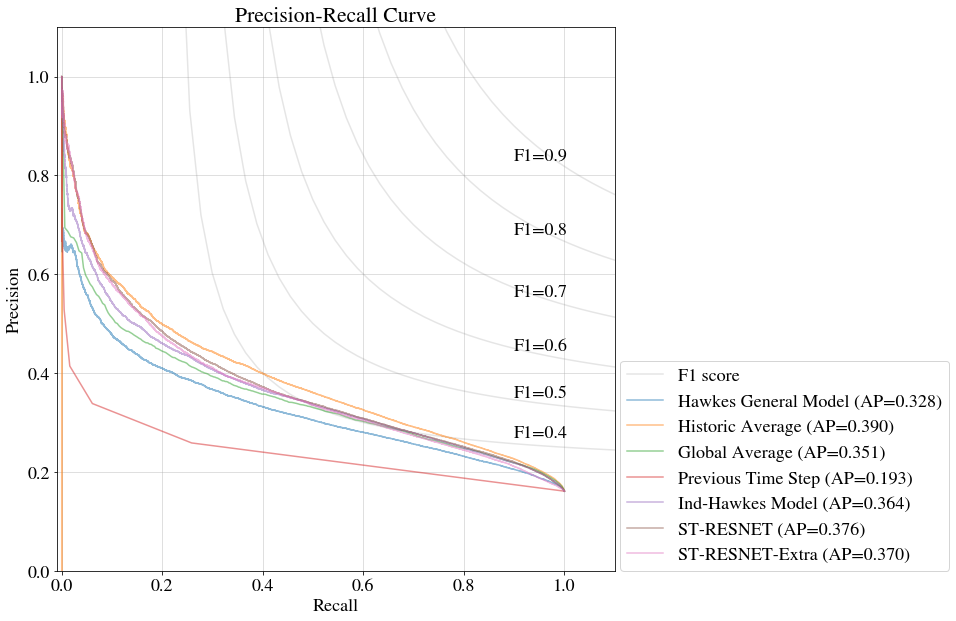

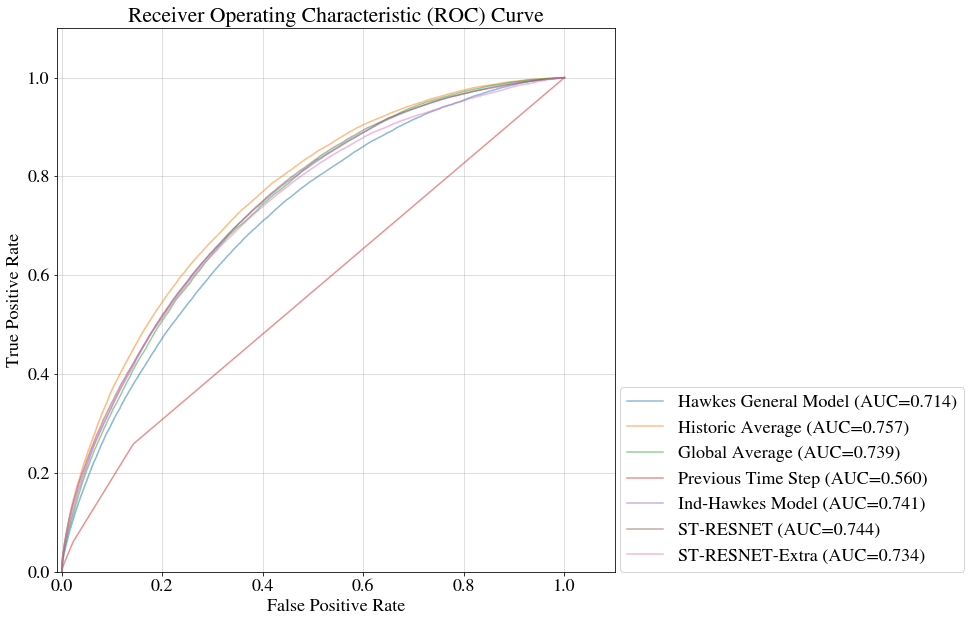

2019-11-12T16:02:04 | root | INFO | 
========================= T12H-X850M-Y880M_2013-01-01_2015-01-01 =========================

2019-11-12T16:02:05 | root | INFO | =====================================BEGIN=====================================
2019-11-12T16:02:06 | root | INFO | Device: cuda:0
2019-11-12T16:02:08 | root | INFO | 	t_range shape (1461,)
2019-11-12T16:02:08 | root | INFO | lr: 		0.0005
2019-11-12T16:02:08 | root | INFO | weight_decay: 	1e-08
2019-11-12T16:02:08 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-12T16:02:08 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T12H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '12H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/

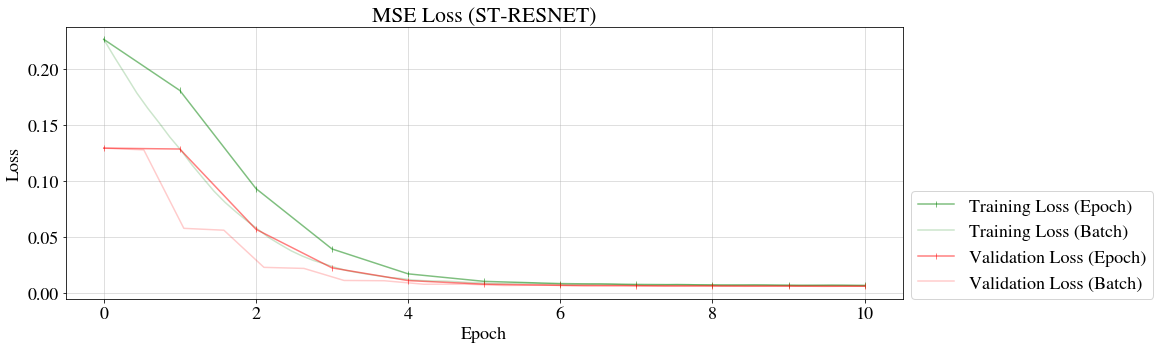

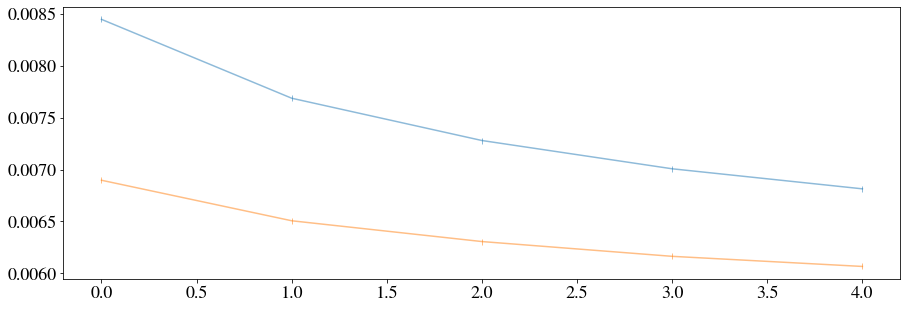

2019-11-12T16:02:23 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T16:02:23 | root | INFO | loading model from ./data/processed/T12H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET/
2019-11-12T16:02:24 | root | INFO | f1_score: 0.5823155109608057 at index 438522, new threshold 0.04960291087627411
2019-11-12T16:02:25 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                ROC AUC:            0.7574991526794214                
                Average Precision:  0.5565258723712181
                Precision:          0.4411246444911586
                Recall:             0.7327086007702183
                Accuracy:           0.6666523500694355
                MCC:                0.33617305741876075          
        
2019-11-12T16:02:25 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.7574991526794214
                Average Precision:  0.5565258723712181       

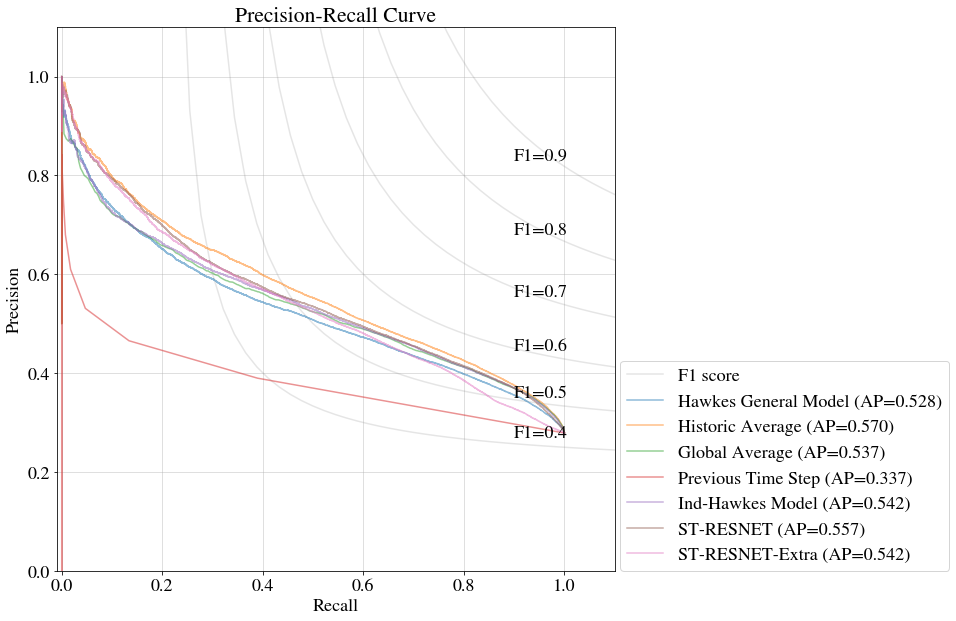

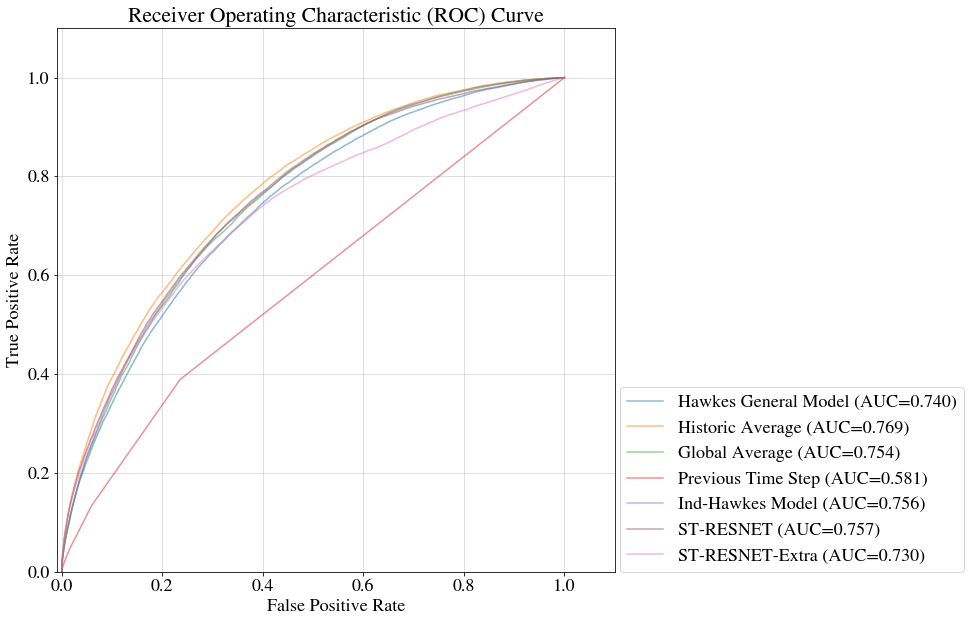

2019-11-12T16:02:34 | root | INFO | =====================================BEGIN=====================================
2019-11-12T16:02:35 | root | INFO | Device: cuda:0
2019-11-12T16:02:35 | root | INFO | 	t_range shape (1461,)
2019-11-12T16:02:35 | root | INFO | lr: 		0.0005
2019-11-12T16:02:35 | root | INFO | weight_decay: 	1e-08
2019-11-12T16:02:35 | root | INFO | 
 ====================== Training ST-RESNET-Extra ====================== 

2019-11-12T16:02:35 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T12H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '12H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET-Extra',
 'model_path': './data/processed/T12H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/',
 'n_channels': 3,
 'n_layers': 5,
 'n_steps_c': 3,
 

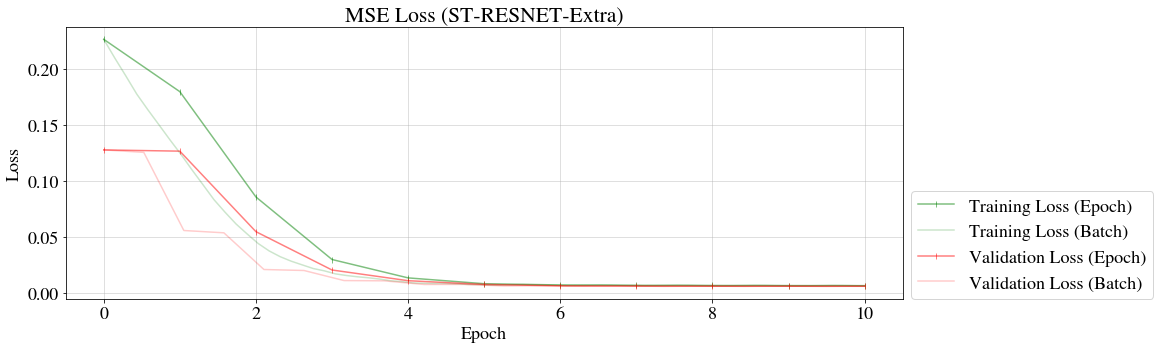

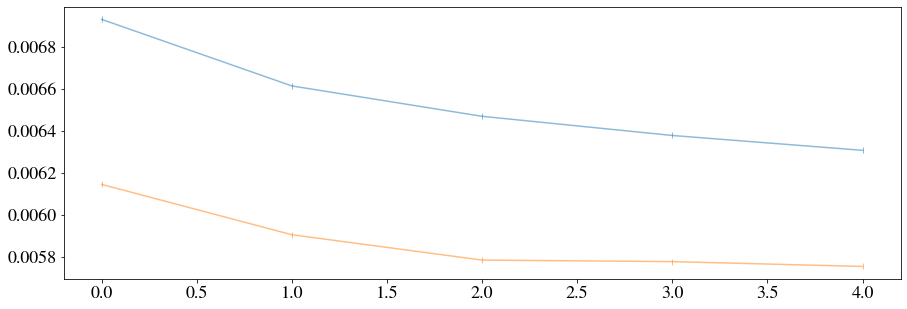

2019-11-12T16:02:52 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T16:02:52 | root | INFO | loading model from ./data/processed/T12H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/
2019-11-12T16:02:53 | root | INFO | f1_score: 0.5776056729564042 at index 490423, new threshold 0.07738978415727615
2019-11-12T16:02:54 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7517841952974804                
                Average Precision:  0.5543187684993337
                Precision:          0.452074941921682
                Recall:             0.6944544287548139
                Accuracy:           0.6801314263625822
                MCC:                0.33443114373225763          
        
2019-11-12T16:02:54 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7517841952974804
                Average Precision:  0.554318

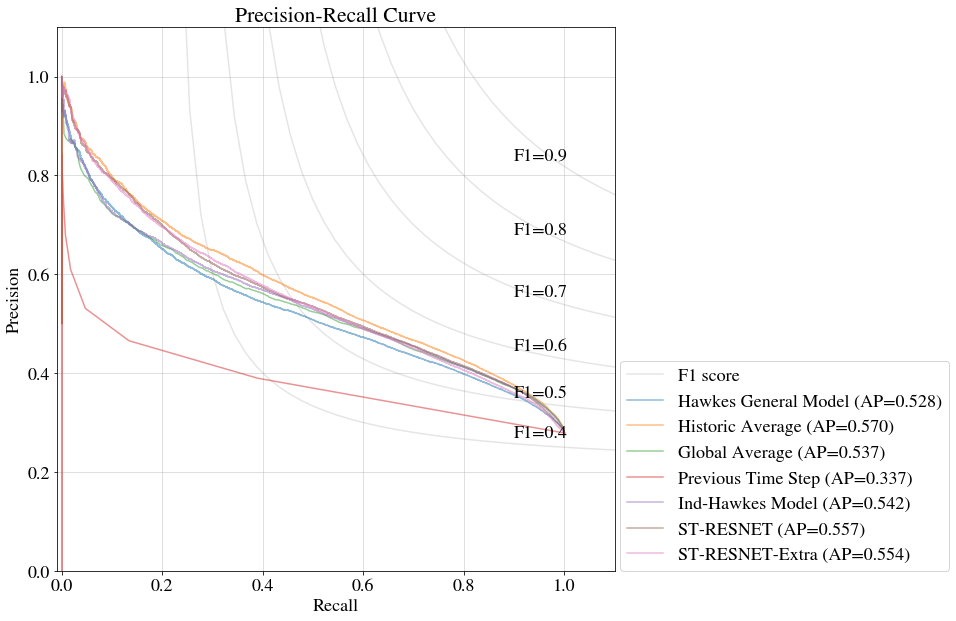

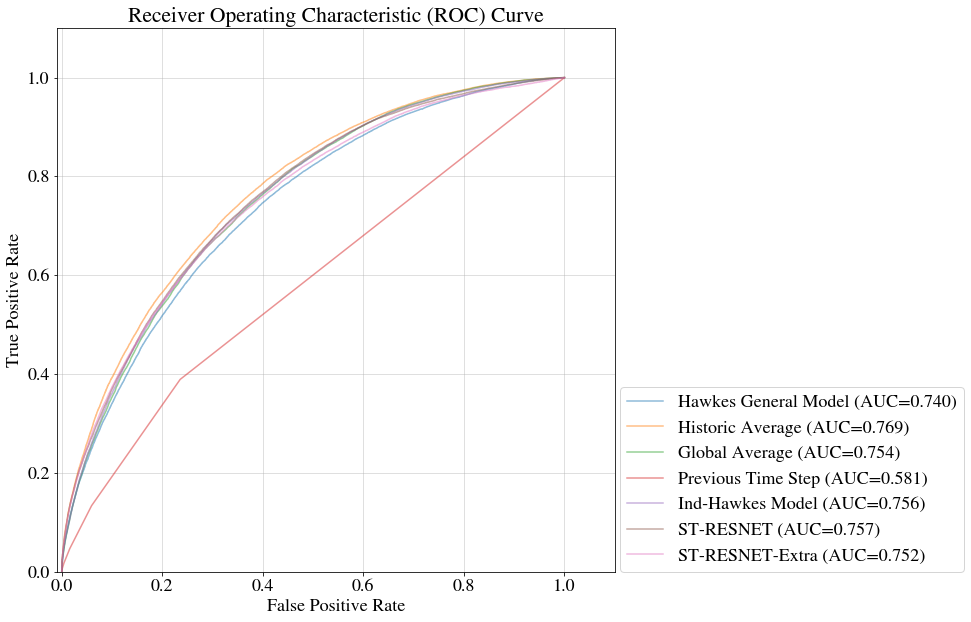

2019-11-12T16:02:57 | root | INFO | 
========================= T24H-X850M-Y880M_2013-01-01_2015-01-01 =========================

2019-11-12T16:02:58 | root | INFO | =====================================BEGIN=====================================
2019-11-12T16:02:59 | root | INFO | Device: cuda:0
2019-11-12T16:03:00 | root | INFO | 	t_range shape (731,)
2019-11-12T16:03:01 | root | INFO | lr: 		0.0005
2019-11-12T16:03:01 | root | INFO | weight_decay: 	1e-08
2019-11-12T16:03:01 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-12T16:03:01 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T

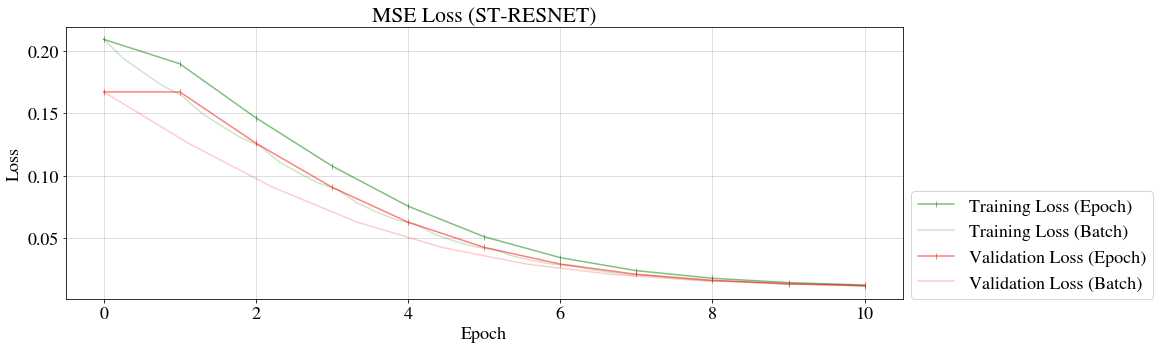

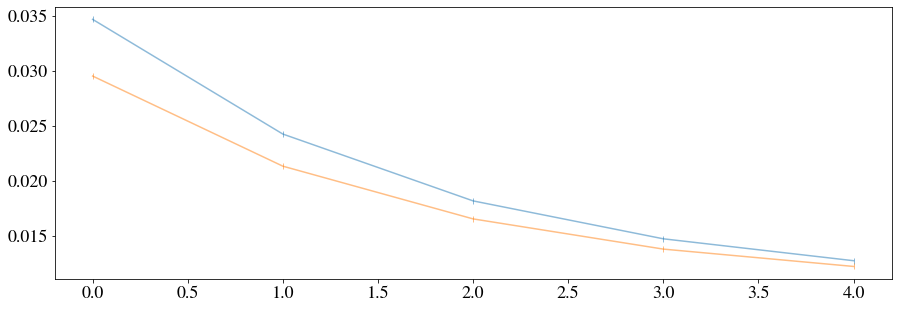

2019-11-12T16:03:14 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T16:03:14 | root | INFO | loading model from ./data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET/
2019-11-12T16:03:15 | root | INFO | f1_score: 0.718918812993579 at index 209885, new threshold 0.09246675670146942
2019-11-12T16:03:15 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                ROC AUC:            0.7736930995021862                
                Average Precision:  0.7401183427374616
                Precision:          0.5340593875081449
                Recall:             0.9197204321759482
                Accuracy:           0.603844714955826
                MCC:                0.31622193643432084          
        
2019-11-12T16:03:15 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.7736930995021862
                Average Precision:  0.7401183427374616         

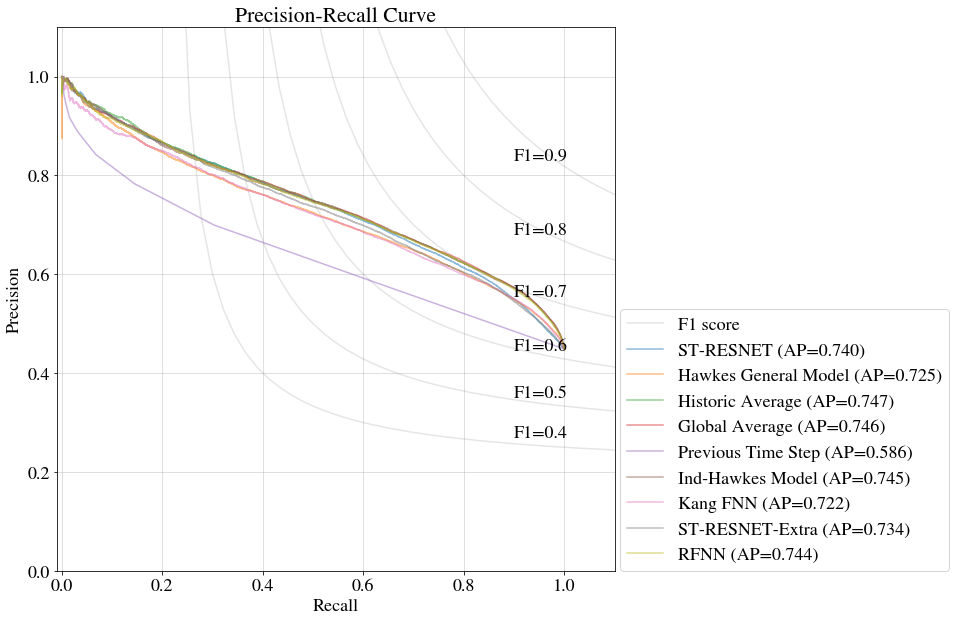

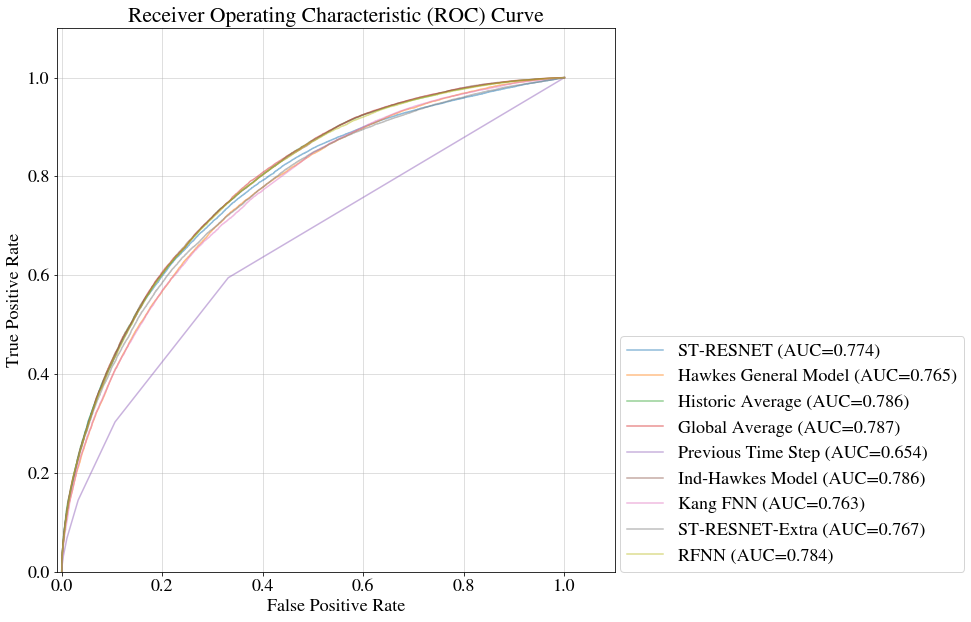

2019-11-12T16:03:23 | root | INFO | =====================================BEGIN=====================================
2019-11-12T16:03:24 | root | INFO | Device: cuda:0
2019-11-12T16:03:24 | root | INFO | 	t_range shape (731,)
2019-11-12T16:03:24 | root | INFO | lr: 		0.0005
2019-11-12T16:03:24 | root | INFO | weight_decay: 	1e-08
2019-11-12T16:03:24 | root | INFO | 
 ====================== Training ST-RESNET-Extra ====================== 

2019-11-12T16:03:24 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET-Extra',
 'model_path': './data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/',
 'n_channels': 3,
 'n_layers': 5,
 'n_steps_c': 3,
 '

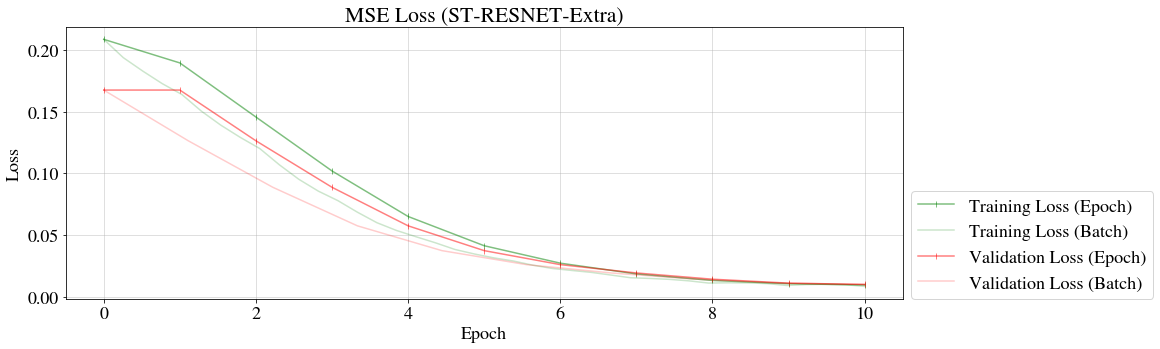

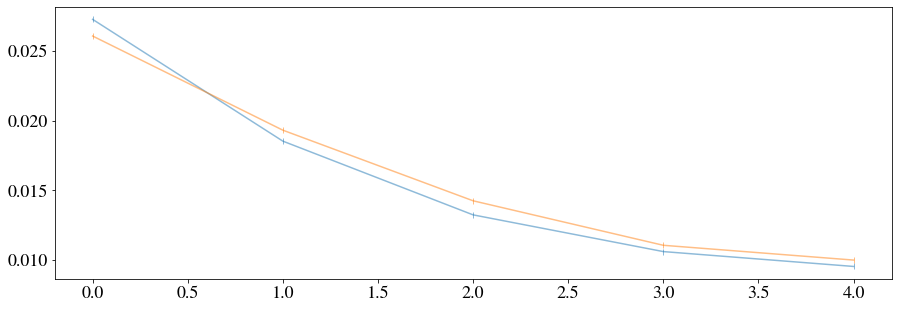

2019-11-12T16:03:38 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T16:03:38 | root | INFO | loading model from ./data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/
2019-11-12T16:03:38 | root | INFO | f1_score: 0.7171161400399434 at index 223602, new threshold 0.09855283051729202
2019-11-12T16:03:39 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7695479270307821                
                Average Precision:  0.733298409174439
                Precision:          0.605536821751126
                Recall:             0.8232823570901863
                Accuracy:           0.6799907911019022
                MCC:                0.39426117714731457          
        
2019-11-12T16:03:39 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7695479270307821
                Average Precision:  0.7332984

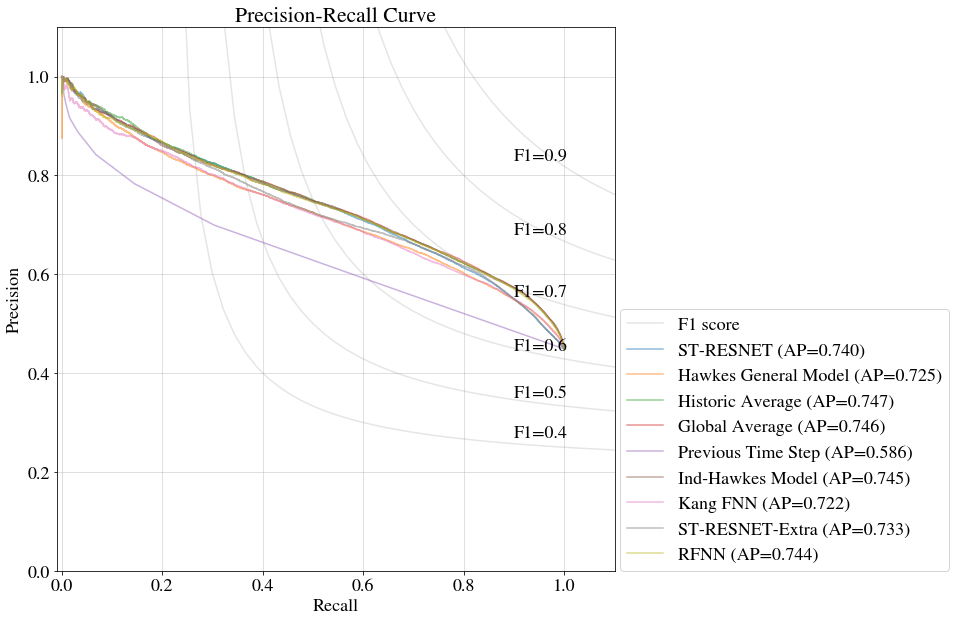

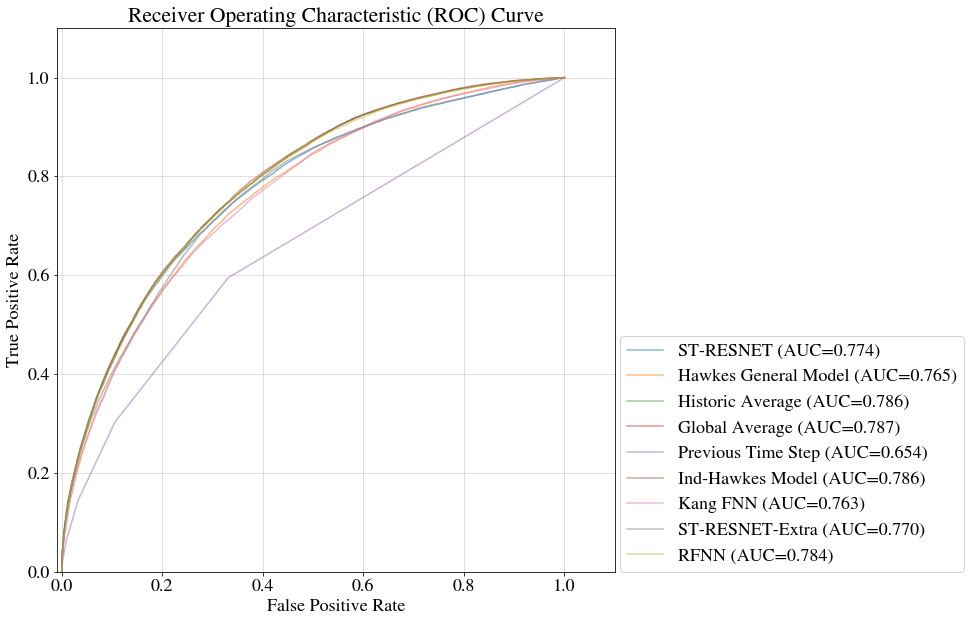

2019-11-12T16:03:41 | root | INFO | 
========================= T24H-X425M-Y440M_2013-01-01_2015-01-01 =========================

2019-11-12T16:03:41 | root | INFO | =====================================BEGIN=====================================
2019-11-12T16:03:42 | root | INFO | Device: cuda:0
2019-11-12T16:03:45 | root | INFO | 	t_range shape (731,)
2019-11-12T16:03:47 | root | INFO | lr: 		0.0005
2019-11-12T16:03:47 | root | INFO | weight_decay: 	1e-08
2019-11-12T16:03:47 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-12T16:03:47 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T

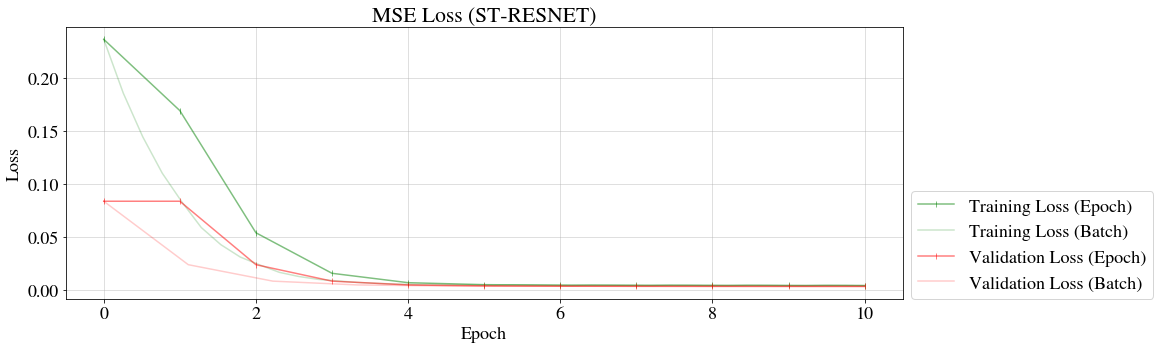

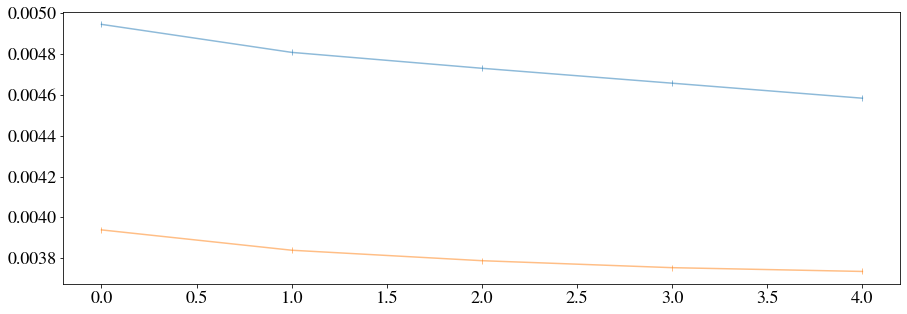

2019-11-12T16:04:50 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T16:04:50 | root | INFO | loading model from ./data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/models/ST-RESNET/
2019-11-12T16:04:52 | root | INFO | f1_score: 0.4570176608432243 at index 676106, new threshold 0.01852329634130001
2019-11-12T16:04:53 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                ROC AUC:            0.7160607488520496                
                Average Precision:  0.3951333796347277
                Precision:          0.29321903294162976
                Recall:             0.7084972187958201
                Accuracy:           0.622736056214317
                MCC:                0.2445447746339382          
        
2019-11-12T16:04:53 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.7160607488520496
                Average Precision:  0.3951333796347277        

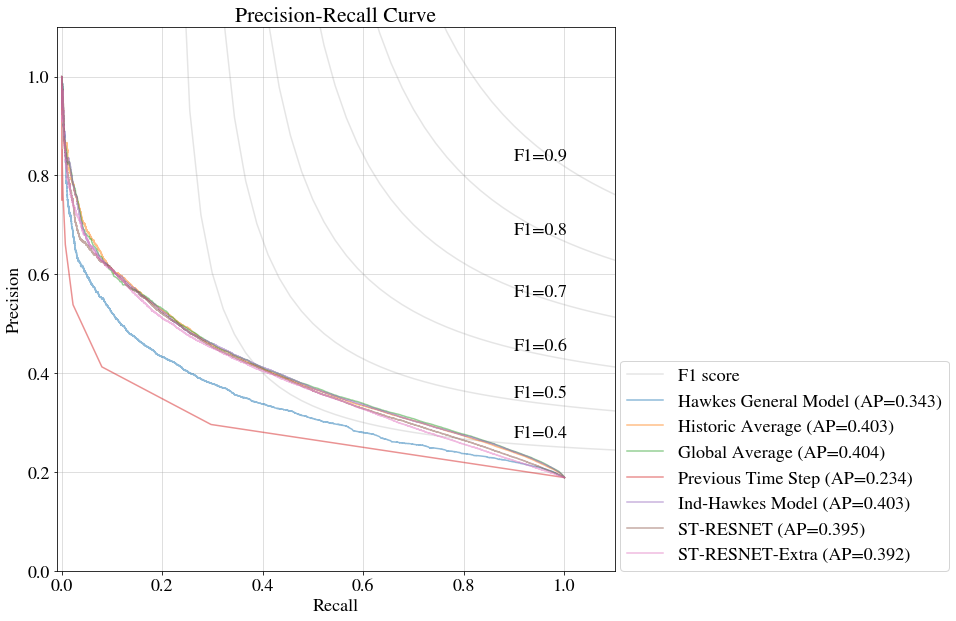

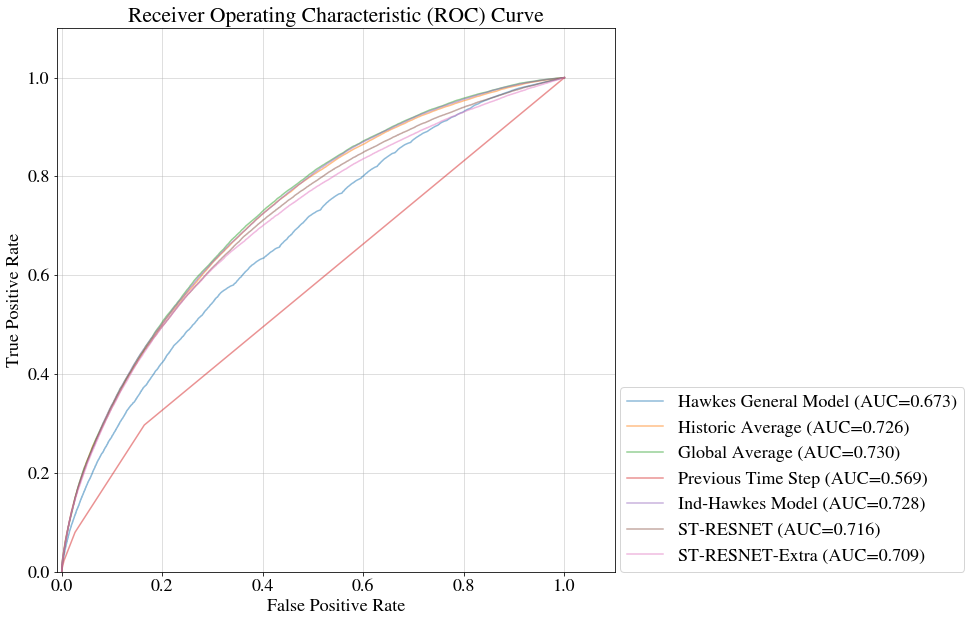

2019-11-12T16:05:03 | root | INFO | =====================================BEGIN=====================================
2019-11-12T16:05:03 | root | INFO | Device: cuda:0
2019-11-12T16:05:04 | root | INFO | 	t_range shape (731,)
2019-11-12T16:05:04 | root | INFO | lr: 		0.0005
2019-11-12T16:05:04 | root | INFO | weight_decay: 	1e-08
2019-11-12T16:05:04 | root | INFO | 
 ====================== Training ST-RESNET-Extra ====================== 

2019-11-12T16:05:04 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET-Extra',
 'model_path': './data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/',
 'n_channels': 3,
 'n_layers': 5,
 'n_steps_c': 3,
 '

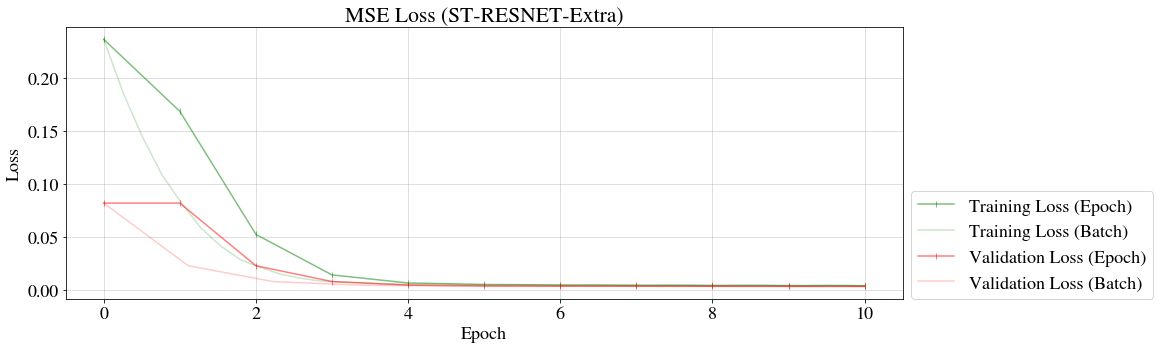

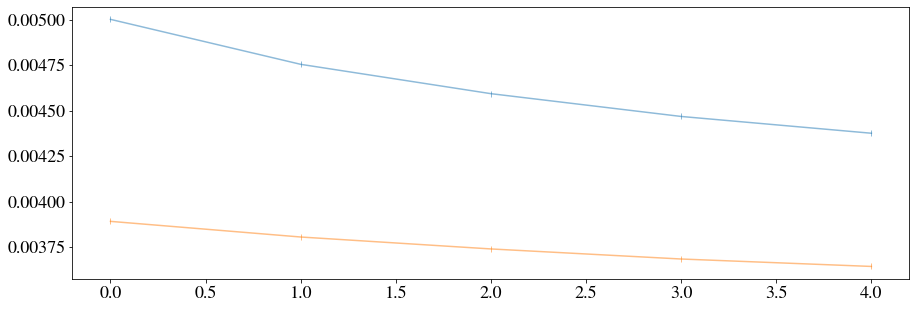

2019-11-12T16:06:13 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T16:06:13 | root | INFO | loading model from ./data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/
2019-11-12T16:06:15 | root | INFO | f1_score: 0.4528561921900164 at index 846062, new threshold 0.01797923818230629
2019-11-12T16:06:16 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7141193101928107                
                Average Precision:  0.3938141344190758
                Precision:          0.3189272192331587
                Recall:             0.6332301533735192
                Accuracy:           0.6756170399648661
                MCC:                0.2576257031527903          
        
2019-11-12T16:06:16 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7141193101928107
                Average Precision:  0.393814

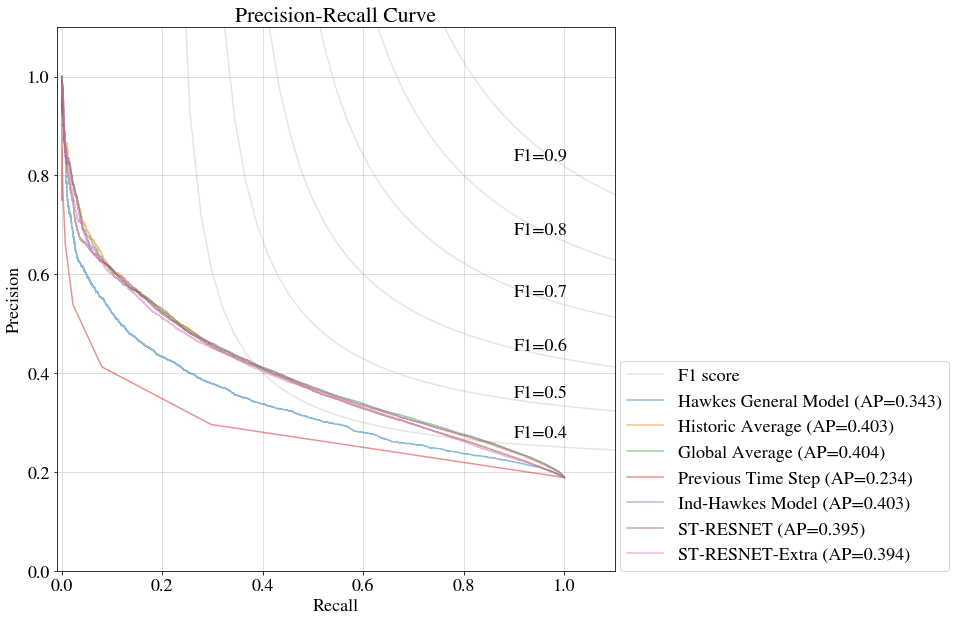

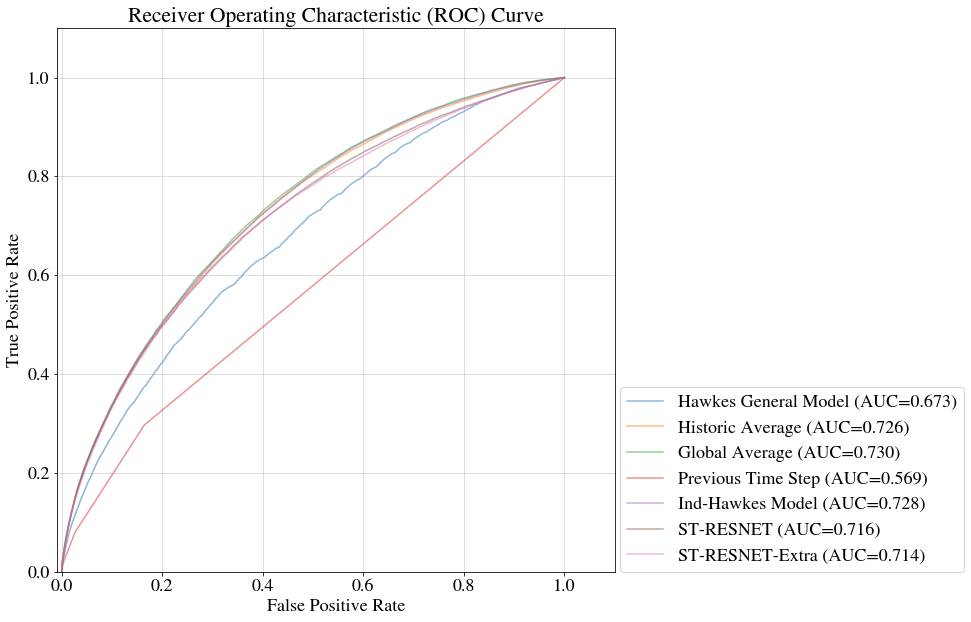

2019-11-12T16:06:21 | root | INFO | 
========================= T24H-X255M-Y220M_2013-01-01_2015-01-01 =========================

2019-11-12T16:06:21 | root | INFO | =====================================BEGIN=====================================
2019-11-12T16:06:21 | root | INFO | Device: cuda:0
2019-11-12T16:06:21 | root | INFO | 	t_range shape (731,)
2019-11-12T16:06:27 | root | INFO | lr: 		0.0005
2019-11-12T16:06:27 | root | INFO | weight_decay: 	1e-08
2019-11-12T16:06:27 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-12T16:06:27 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T24H-X255M-Y220M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T

In [0]:
for data_sub_path in data_sub_paths:
    log.info(f"\n========================= {data_sub_path} =========================\n")    
    for USE_EXTRA in [False, True]:
        
        conf = BaseConf()
        if USE_EXTRA:
            conf.model_name = "ST-RESNET-Extra"  # needs to be created
        else:     
            conf.model_name = "ST-RESNET"  # needs to be created

        conf.data_path = f"./data/processed/{data_sub_path}/"

        if not os.path.exists(conf.data_path):
            raise Exception(f"Directory ({conf.data_path}) needs to exist.")

        conf.model_path =  f"{conf.data_path}models/{conf.model_name}/"
        os.makedirs(conf.data_path, exist_ok=True)
        os.makedirs(conf.model_path, exist_ok=True)

        # logging config is set globally thus we only need to call this in this file
        # imported function logs will follow the configuration
        setup_logging(save_dir=conf.model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
        log.info("=====================================BEGIN=====================================")

        info = deepcopy(conf.__dict__)
        info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

        # DATA LOADER SETUP
        np.random.seed(conf.seed)
        use_cuda = torch.cuda.is_available()
        if use_cuda:
            torch.cuda.manual_seed( conf.seed)
        else:
            torch.manual_seed(conf.seed)

        device = torch.device("cuda:0" if use_cuda else "cpu")
        log.info(f"Device: {device}")
        info["device"] = device.type
        conf.device = device

        conf.batch_size = 64

        # CRIME DATA
        data_group = GridDataGroup(data_path=conf.data_path,
                                conf=conf)

        loaders = GridDataLoaders(data_group=data_group,
                                conf=conf)

        # SET THE HYPER PARAMETERS
        conf.dropout = 0#0.2
        conf.weight_decay = 1e-8
        conf.lr = 5e-4
        conf.checkpoint =  "best" # "latest" # 
        conf.resume = False
        conf.freqstr = data_group.t_range.freqstr  
        conf.early_stopping = False
        conf.max_epochs = 10

        # SET LOSS FUNCTION
        # size averaged - so more epochs or larger lr for smaller batches
        loss_function = nn.MSELoss()  

        # SETUP MODEL
        dataset = loaders.train_loader.dataset
        _, h_size, w_size = dataset.crimes.shape
        _, n_ext_features = dataset.time_vectors.shape


        # todo setup - hyper-optimiser
        conf.n_layers = 12  # number of res-unit layers
        conf.n_channels = 3 # inner channel size of the res-units 

        if USE_EXTRA:
            train_epoch_fn = train_epoch_for_st_res_net_extra
            evaluate_fn = evaluate_st_res_net_extra
            model = STResNetExtra(n_layers=conf.n_layers,
                                n_channels=conf.n_channels,
                                y_size=h_size,
                                x_size=w_size,

                                lc=dataset.n_steps_c,
                                lp=dataset.n_steps_p,
                                lq=dataset.n_steps_q,

                                n_ext_features=n_ext_features,
                                n_demog_features=37,
                                n_demog_channels=10,
                                n_demog_layers=3,

                                n_gsv_features=512,
                                n_gsv_channels=10,
                                n_gsv_layers=3)
        else:
            train_epoch_fn = train_epoch_for_st_res_net
            evaluate_fn = evaluate_st_res_net
            model = STResNet(n_layers=conf.n_layers,
                            n_channels=conf.n_channels,
                            y_size=h_size,
                            x_size=w_size,

                            lc=dataset.n_steps_c,
                            lp=dataset.n_steps_p,
                            lq=dataset.n_steps_q,

                            n_ext_features=n_ext_features)    
            
        # todo implement model_arch for res-net
        model.to(conf.device)

        # SETUP OPTIMISER
        parameters = model.parameters()
        # todo (optional): setup model parameters dynamically 

        optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

        if conf.resume:
            try:
                # resume from previous check point or resume from best validaton score checkpoint
                # load model state
                model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                            map_location=conf.device.type)
                model.load_state_dict(model_state_dict)
                
                # load optimiser state
                optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                                map_location=conf.device.type)
                optimiser.load_state_dict(optimiser_state_dict) 

                # new optimiser hyper-parameters
                optimiser.param_groups[0]['lr'] = conf.lr
                optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

            except Exception as e:
                log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")


        log.info(f"lr: \t\t{optimiser.param_groups[0]['lr']}")
        log.info(f"weight_decay: \t{optimiser.param_groups[0]['weight_decay']}")
        trn_epoch_losses, val_epoch_losses, stopped_early = train_model(model=model,
                                                optimiser=optimiser,
                                                loaders=loaders,
                                                train_epoch_fn=train_epoch_fn,
                                                loss_fn=loss_function,
                                                conf=conf)    

        print(f"stopped_early: {stopped_early}") # use the current epoch instead
        # if stopped_early -> continue with best_model - new hyper-parameters -> no n 

        plt.figure(figsize=(15,5))
        for x in [trn_epoch_losses, val_epoch_losses]:
            plt.plot(x[-5:],marker='|',alpha=.5)
        plt.show()

        # Load latest or best validation model
        # conf.checkpoint = "latest"
        conf.checkpoint = "best"

        log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

        # resume from previous check point or resume from best validaton score checkpoint
        # load model state
        log.info(f"loading model from {conf.model_path}")
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                        map_location=conf.device.type)
        model.load_state_dict(model_state_dict)

        trn_y_counts, trn_y_true, trn_probas_pred, trn_t_range = evaluate_fn(model=model,
                                                                            batch_loader=loaders.train_loader,
                                                                            conf=conf) 
        thresh = best_threshold(trn_y_true, trn_probas_pred) 

        tst_y_counts, tst_y_true, tst_probas_pred, tst_t_range = evaluate_fn(model=model,
                                                                            batch_loader=loaders.test_loader,
                                                                            conf=conf)


        tst_y_true = np.expand_dims(tst_y_true, axis=1)
        tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1) 

        tst_y_true = data_group.shaper.squeeze(tst_y_true)
        tst_probas_pred = data_group.shaper.squeeze(tst_probas_pred)


        tst_y_pred = get_y_pred(thresh, tst_probas_pred)
        save_metrics(y_true=tst_y_true,
                    y_pred=tst_y_pred,
                    probas_pred=tst_probas_pred,
                    t_range=tst_t_range,
                    shaper=data_group.shaper,                
                    conf=conf)
        compare_models(data_path=conf.data_path)

In [0]:
for data_sub_path in get_data_sub_paths():
    log.info(f"{data_sub_path}\n")
    data_path = f"./data/processed/{data_sub_path}/"

    models_metrics = get_models_metrics(data_path)
    metrics_table = get_metrics_table(models_metrics)
    print(metrics_table)
    print("\n===================================================================================================\n")